# Flight Price Prediction

Statistical learning project

a.y. 2022/2023

**group 13/15:**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import optimize
import random                                    
from math import isnan
from sklearn import datasets, linear_model
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, make_scorer


from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, MinMaxScaler
from sklearn.decomposition import PCA, KernelPCA
from scipy import stats
from sklearn.model_selection import train_test_split, cross_val_score
from datetime import datetime
import re
import os



**Data Cleaning**

In [29]:

cartella = r'C:\Users\loren\Downloads\progettoSL\scraping'

elenco_file = [file for file in os.listdir(cartella) if file.endswith('.xlsx')]

if not elenco_file:
    print("Nessun file Excel trovato nella cartella.")
else:
    primo_file = os.path.join(cartella, elenco_file[0])
    df_completo = pd.read_excel(primo_file)

    col_name_mapping = {
        'data-ril': 'data_ril',
        'dara_ril': 'data_ril',
        'dati_ril': 'data_ril',
        'aeroproto_partenza': 'aeroporto_partenza',
        'oario_partenza':'orario_partenza',
        'oario_arrivo':'orario_arrivo',
        'orario_arrivp':'orario_arrivo',
        'orario_partenzal':'orario_partenza',
        'orariopartenza':'orario_partenza',
        'orario_partenza ':'orario_partenza',
        'Tariffa': 'tariffa',
        'tariffa ': 'tariffa',
        'tariffa  ': 'tariffa',
        'tariffa   ': 'tariffa',
        'operatore ':'operatore',
        'data_partenza ':'data_partenza',
        'data_ril ':'data_ril'
    }

    for col_old, col_new in col_name_mapping.items():
        if col_old in df_completo.columns:
            df_completo.rename(columns={col_old: col_new}, inplace=True)

    for file in elenco_file[1:]:
        percorso_file = os.path.join(cartella, file)
        df = pd.read_excel(percorso_file)

        for col_old, col_new in col_name_mapping.items():
            if col_old in df.columns:
                df.rename(columns={col_old: col_new}, inplace=True)

        df_completo = pd.concat([df_completo, df], ignore_index=True)

    percorso_output = r'C:\Users\loren\Downloads\progettoSL\dataset.xlsx'

    df_completo.to_excel(percorso_output, index=False)



In [2]:
data = pd.read_excel('dataset.xlsx')

In [3]:
data

,orario_partenza,orario_arrivo,aeroporto_partenza,aeroporto_arrivo,tipo,durata,operatore,prezzo,tariffa,data_partenza,data_ril,distanza
0,6:15,9:25,FCO,JTR,diretto,2h 10m,Vueling,127 €,Economy,lun 24/7,21\6',1273
1,6:15,9:25,FCO,JTR,diretto,2h 10m,Vueling,127 €,Economy,lun 24/7,21\6',1273
2,7:05,23:59,FCO,JTR,1 scalo,15h 54m,Ryanair,76 €,Tariffa Standard,lun 24/7,21\6',1273
3,6:15,9:25,FCO,JTR,diretto,2h 10m,Iberia,268 €,Tariffa di base,lun 24/7,21\6',1273
4,17:05,23:30,FCO,JTR,1 scalo,5h 25m,"Aeroitalia, Volotea",102 €,Economy,lun 24/7,21\6',1273
...,...,...,...,...,...,...,...,...,...,...,...,...
86488,17:35,1:20+1,FCO,KEF,1 scalo,9h 45m,"Vueling, PLAY",442 €,Economy,dom 20/8,18\7',3322
86489,11:25,0:10+1,FCO,KEF,1 scalo,14h 45m,Scandinavian Airlines,437 €,Economy,dom 20/8,18\7',3322
86490,20:50,9:45+1,FCO,KEF,1 scalo,14h 55m,Scandinavian Airlines,437 €,Economy,dom 20/8,18\7',3322
86491,13:25,23:30,FCO,KEF,1 scalo,12h 05m,Lufthansa,498 €,Economy Light,dom 20/8,18\7',3322


In [29]:
#in order to remove some data from july
pattern = r'[a-z]{3} \d{2}/7'  # Corrisponde a due cifre, seguite da /7

data = data[~data['data_partenza'].str.match(pattern)]

Features Engineering

In [4]:
data = pd.read_excel('dataset.xlsx')

In [30]:
data.dropna(inplace = True)

data = data[~data.index.duplicated(keep='first')]

data = data[~data['orario_arrivo'].str.contains('\+1')]
data = data[~data['operatore'].str.contains('Flixbus')]
data = data[~data['operatore'].str.contains('FlixBus')]
data = data[~data['aeroporto_partenza'].str.contains('DBV')]
data = data[~data['operatore'].str.contains('Treno')]
data = data[~data['operatore'].str.contains('Italotreno')]
data = data[~data['operatore'].str.contains('Trenitalia')]
data = data[~data['tipo'].str.contains('2 scali')]
#data = data[~data['operatore'].str.contains('Aeroitalia')]

In [31]:
def clean_price(value):
    if isinstance(value, (int, float)):
        return value
    try:
        new_price = int(re.sub(r'[^\d]', '', str(value)))
        return new_price
    except:
        return None

data['prezzo'] = data['prezzo'].apply(clean_price)
#data.dropna(subset=['prezzo'], inplace=True)


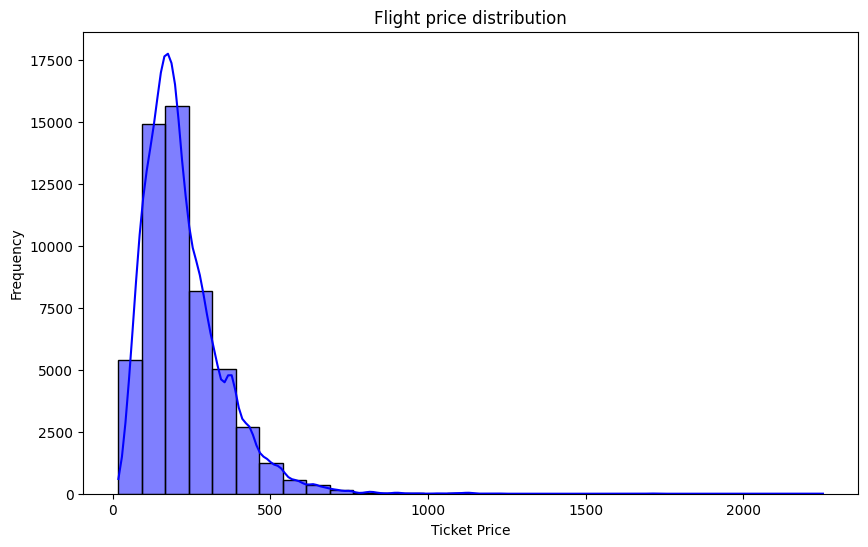

In [32]:
#price data visualization
plt.figure(figsize=(10, 6)) 

sns.histplot(data['prezzo'], bins=30, color='blue', kde=True)

plt.xlabel('Ticket Price')
plt.ylabel('Frequency')
plt.title('Flight price distribution')

plt.show()


In [33]:
def transform_row(row):
    if row['tipo'] == 'diretto':
        row['tipo'] = 0
    elif row['tipo'] == '1 scalo' or row['tipo'] == '1 cambio':
        row['tipo'] = 1
    return row

data = data.apply(transform_row, axis=1)


<Figure size 800x600 with 0 Axes>

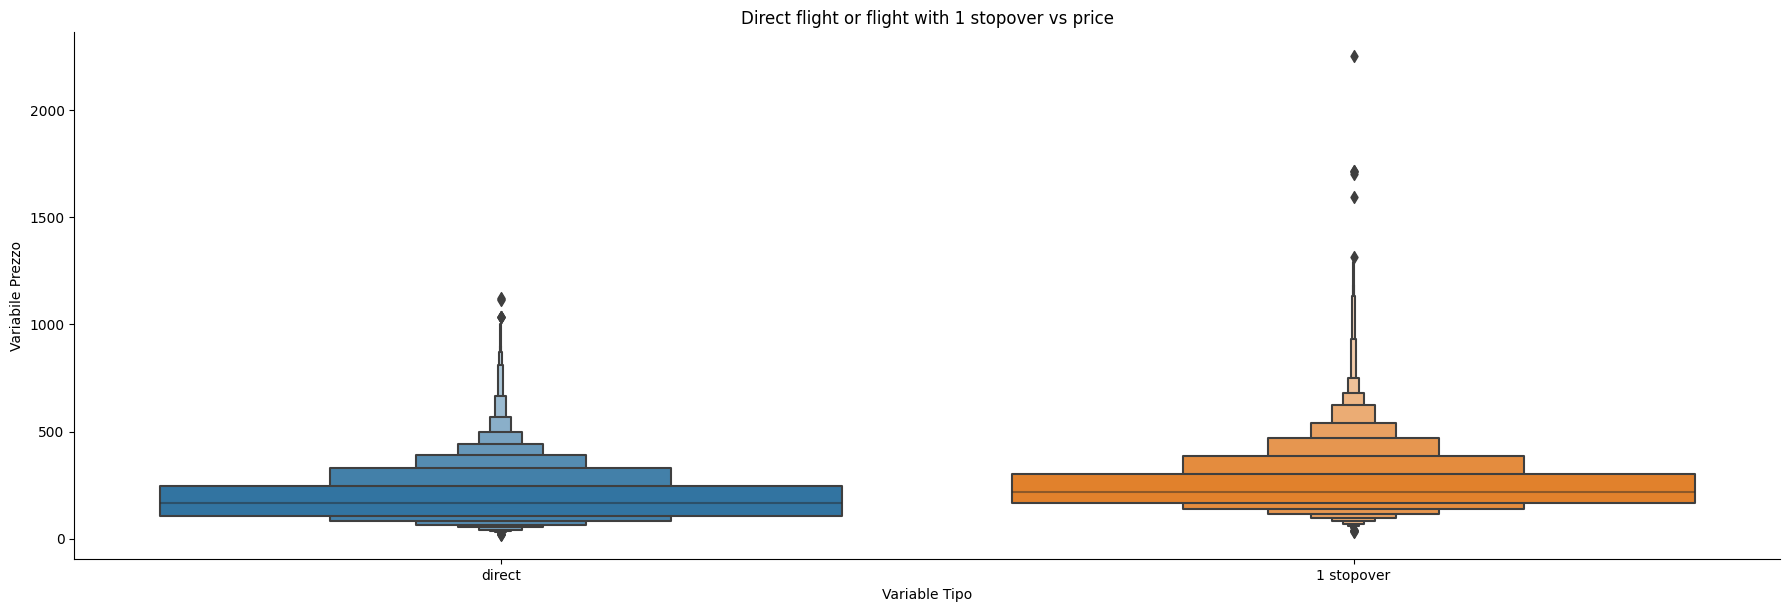

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

#violin plot Tipo-Prezzo
plt.figure(figsize=(8, 6))
sns.catplot(x='tipo', y='prezzo', data = data.sort_values("prezzo", ascending = False), kind="boxen", order= [0,1], height = 6, aspect = 3)
plt.title('Direct flight or flight with 1 stopover vs price')
plt.xticks([0, 1], ['direct','1 stopover'])  
plt.xlabel('Variable Tipo')
plt.ylabel('Variabile Prezzo')
plt.show()

In [35]:
def convert_hours_minutes_to_minutes(duration_str):
    match = re.match(r'(\d+)h (\d+)m', duration_str)
    
    if match:
        hours = int(match.group(1))
        minutes = int(match.group(2))
        total_minutes = hours * 60 + minutes
        return total_minutes
    else:
        return None

for i in data.index:
    duration_str = data.loc[i, 'durata']
    if isinstance(duration_str, str):
        new_duration = convert_hours_minutes_to_minutes(duration_str)
        data.loc[i, 'durata'] = new_duration

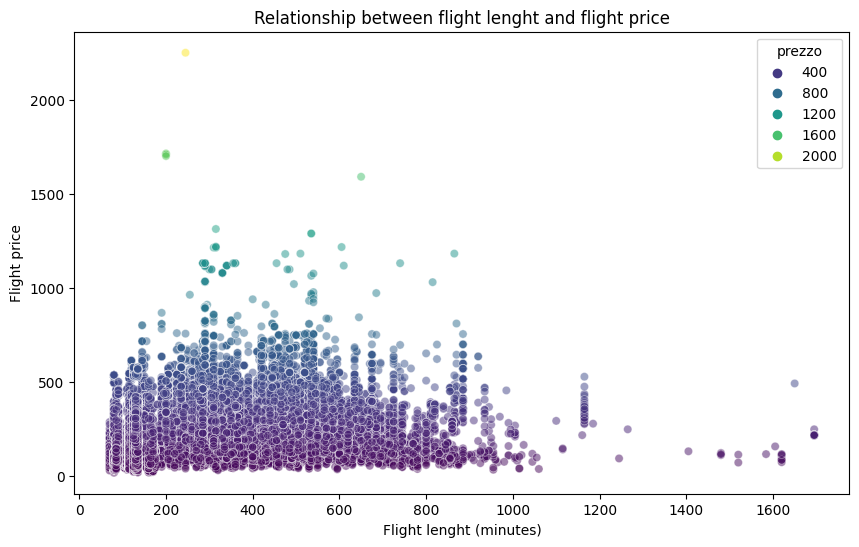

In [36]:
plt.figure(figsize=(10, 6)) 
sns.scatterplot(x=data['durata'], y=data['prezzo'], color='blue', alpha=0.5,  hue=data['prezzo'], palette="viridis")
plt.xlabel('Flight lenght (minutes)')
plt.ylabel('Flight price')
plt.title('Relationship between flight lenght and flight price')
plt.show()

In [37]:
data['tariffa'] = data['tariffa'].replace({'Tariffa Standard': 'Standard', 'Tariffa di base': 'Standard', 'Economy Light': 'Light'})
data['tariffa'] = data['tariffa'].replace({'Economy Saver': 'Economy', 'Economy Flex': 'Economy', 'Economy Standard': 'Economy', 'Economy Classic': 'Economy'})
data['tariffa'] = data['tariffa'].replace({'Business Flessibile': 'Business', 'Business Flex': 'Business', 'Business Light': 'Business', 'Business Optimal': 'Business', 'Business Promozionale': 'Business','Business Saver': 'Business'})
data['tariffa'] = data['tariffa'].replace({'Standard Economy': 'Standard', 'Tariffa flessibile': 'Flex', 'Flessibile': 'Flex', 'Basic Economy':'Basic'})
data['tariffa'] = data['tariffa'].replace({'Classic': 'Standard', 'Discount': 'Economy', 'EcoFly': 'Economy','Saver':'Economy','Smart':'Economy','LowFare':'Economy','Light':'Economy','Basic':'Economy','Optimal':'Economy','Flex':'Economy'})
data['tariffa'] = data['tariffa'].replace({'Saga Premium': 'Business', 'Plus': 'Business', 'Prima classe': 'Business', 'Executive': 'Business'})

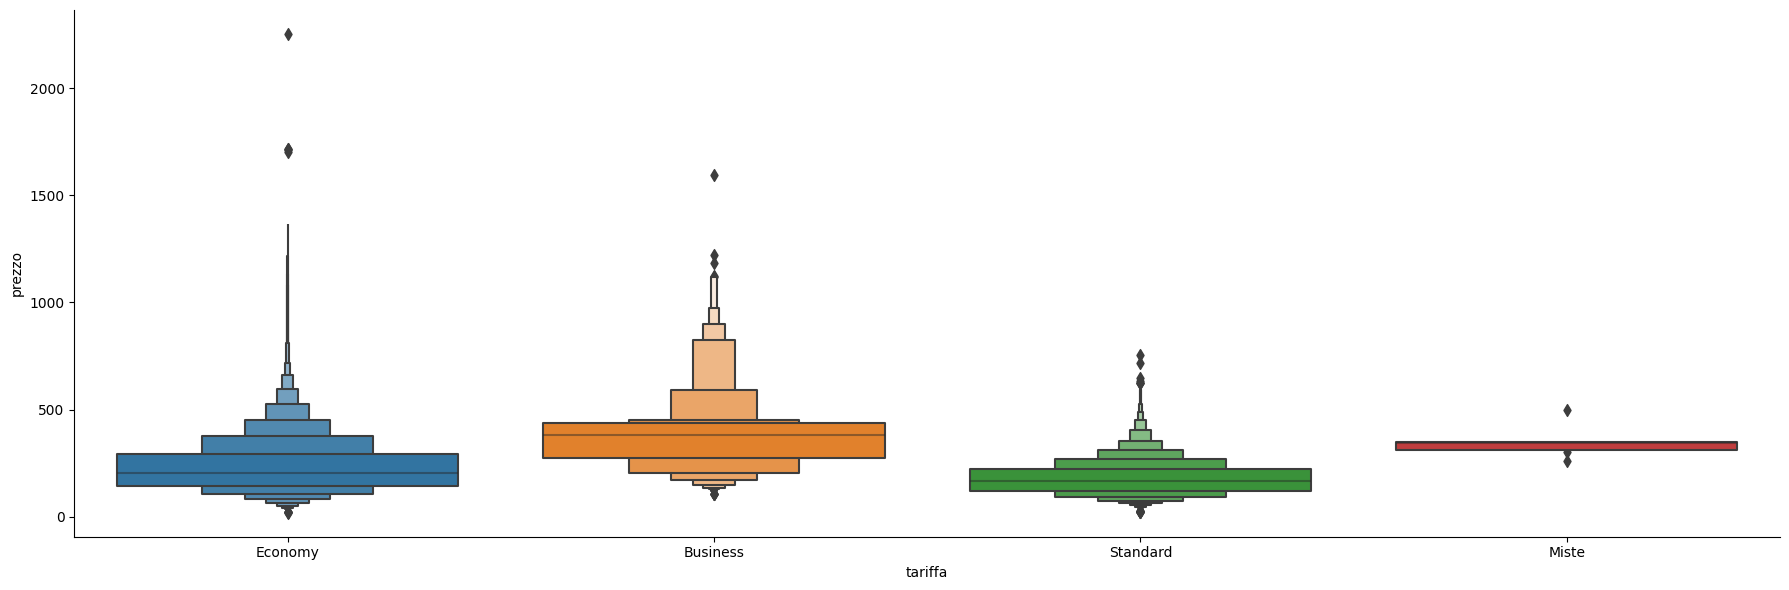

In [38]:
# tariff type vs price
sns.catplot(y = "prezzo", x= 'tariffa', data = data.sort_values("prezzo", ascending = False), kind="boxen", height = 6, aspect = 3)

In [39]:
#dummies for the different tariff types
dummies_tariffa = pd.get_dummies(data['tariffa'], prefix='tariffa')

data = pd.concat([data, dummies_tariffa], axis=1)
data = data.drop('tariffa', axis=1)

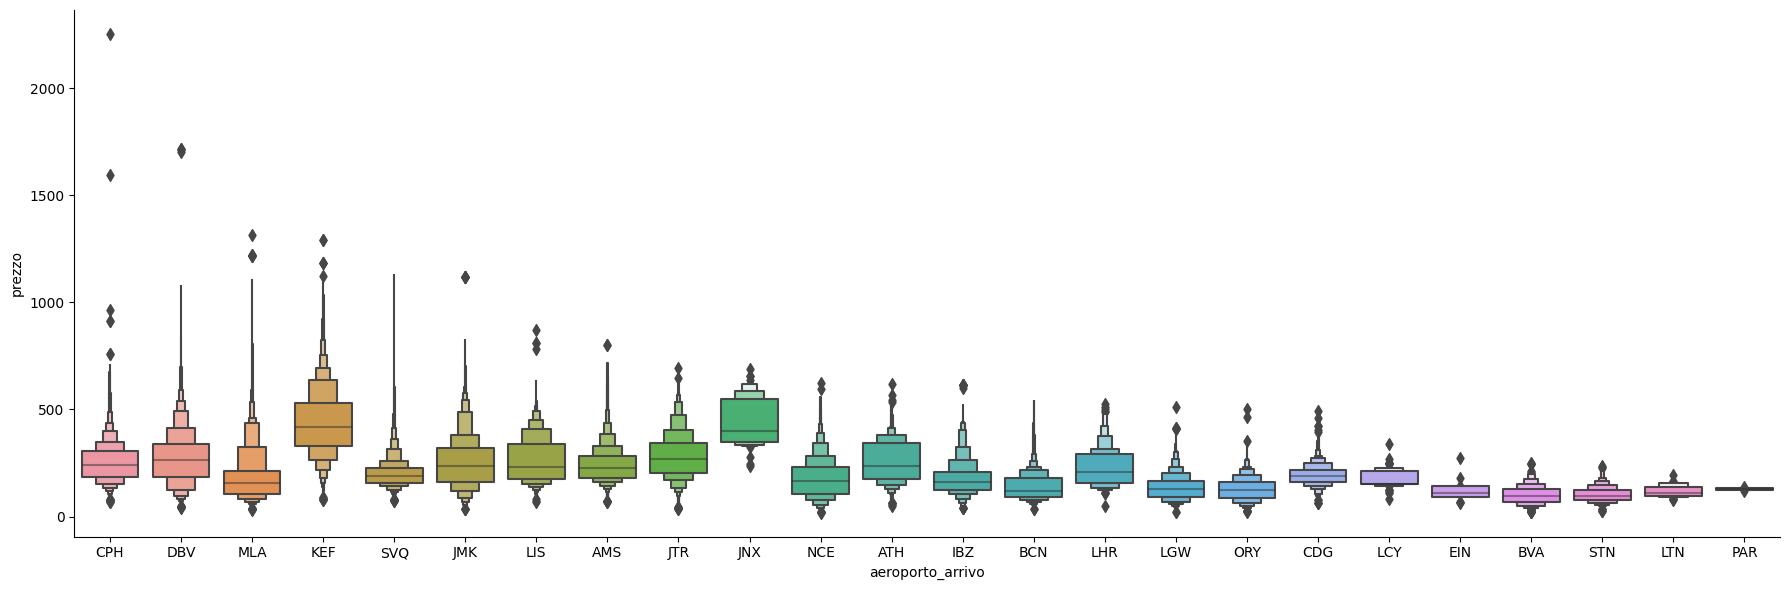

In [40]:
# destination vs price
sns.catplot(y = "prezzo", x= "aeroporto_arrivo", data = data.sort_values("prezzo", ascending = False), kind="boxen", height = 6, aspect = 3)

In [41]:
data['aeroporto_partenza'] = data['aeroporto_partenza'].replace({'ROM': 'FCO'})
dummies_aeroporto_partenza = pd.get_dummies(data['aeroporto_partenza'], prefix='aeroporto_partenza')


dummies_aeroporto_arrivo = pd.get_dummies(data['aeroporto_arrivo'], prefix='aeroporto_arrivo')
data = pd.concat([data, dummies_aeroporto_partenza, dummies_aeroporto_arrivo], axis=1)
data = data.drop(['aeroporto_partenza', 'aeroporto_arrivo'], axis=1)

# dummies_operatore = pd.get_dummies(data['operatore'], prefix='operatore')

# data = pd.concat([data, dummies_operatore], axis=1)
data['operatore'] = data['operatore'].replace({'easyJet Europe': 'easyJet'})
data['operatore'] = data['operatore'].replace({'Ryanair UK': 'Ryanair'})
data['operatore'] = data['operatore'].replace({'Transavia France': 'Transavia'})
data.loc[data['operatore'].str.contains(','), 'operatore'] = 'Multiple_Operator'

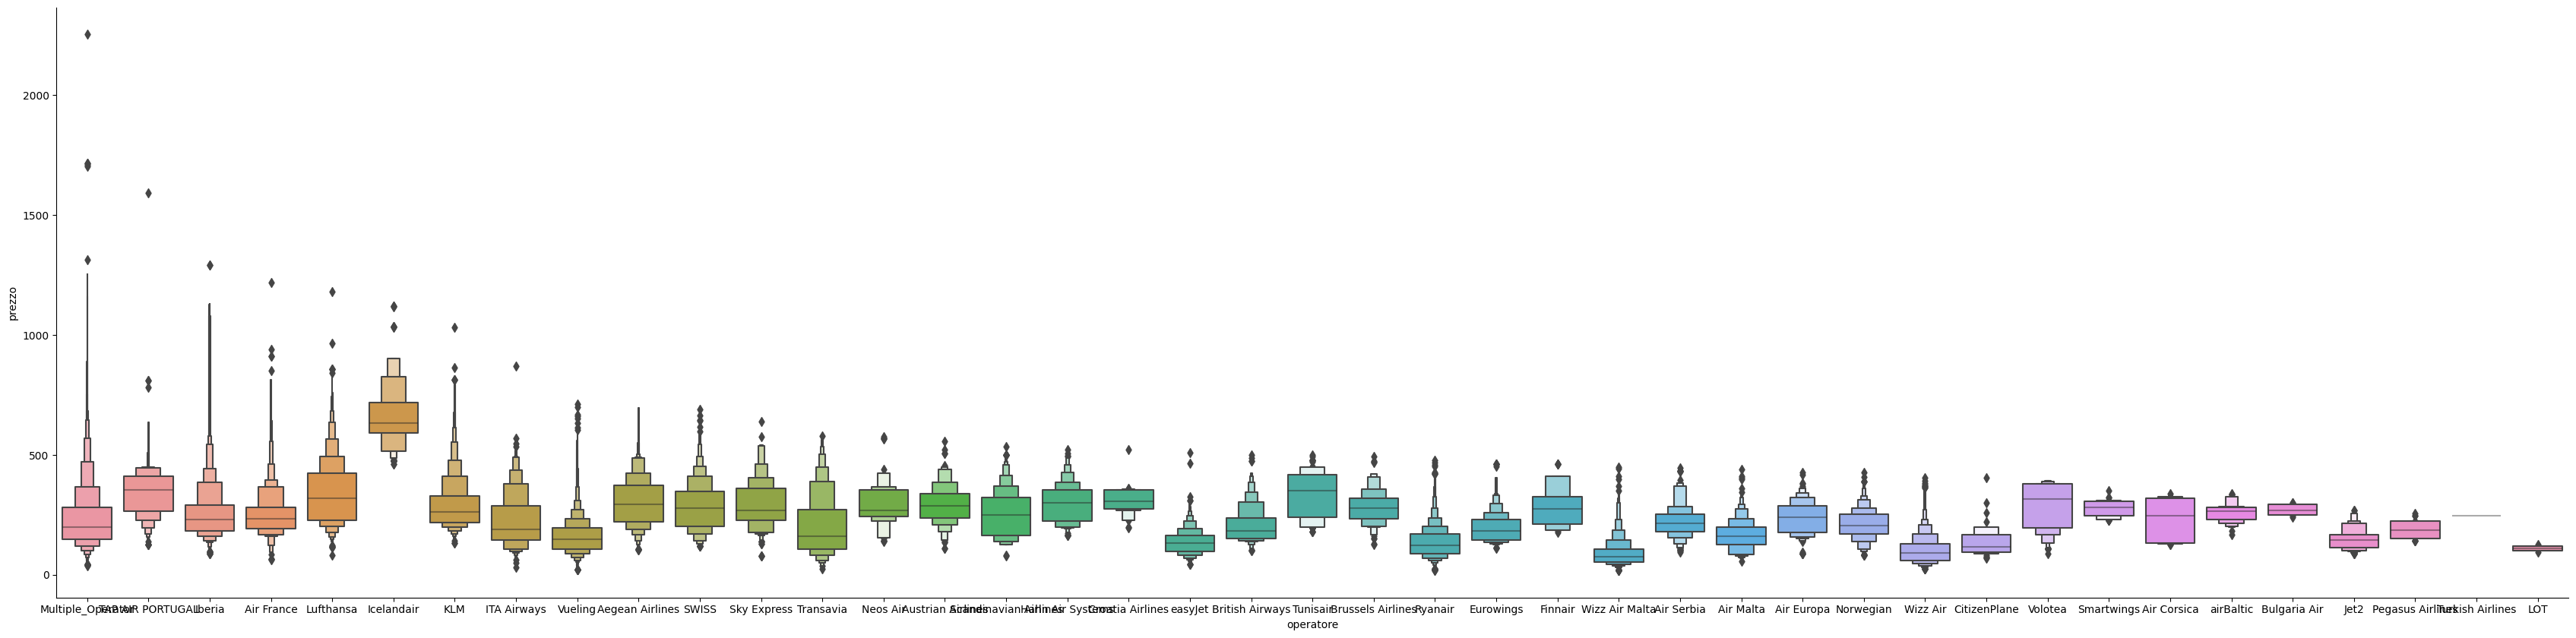

In [42]:
# flight operator vs price
sns.catplot(y = "prezzo", x= "operatore", data = data.sort_values("prezzo", ascending = False), kind="boxen", height = 8.5, aspect = 4)

In [43]:
dummy_operators = data['operatore'].str.get_dummies()
data = pd.concat([data, dummy_operators], axis=1)

data = data.drop('operatore', axis=1)

In [44]:
data['orario_partenza'] = pd.to_datetime(data['orario_partenza'])
data['orario_arrivo'] = pd.to_datetime(data['orario_arrivo'], utc=True)

/var/folders/bn/wptj_gcx0llfvd63nv5lykrr0000gn/T/ipykernel_5229/3511801520.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['orario_partenza'] = pd.to_datetime(data['orario_partenza'])
/var/folders/bn/wptj_gcx0llfvd63nv5lykrr0000gn/T/ipykernel_5229/3511801520.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['orario_arrivo'] = pd.to_datetime(data['orario_arrivo'], utc=True)


In [45]:

data['partenza_0-8'] = (data['orario_partenza'].dt.hour >= 0) & (data['orario_partenza'].dt.hour < 8)
data['partenza_8-16'] = (data['orario_partenza'].dt.hour >= 8) & (data['orario_partenza'].dt.hour < 16)
data['partenza_16-24'] = (data['orario_partenza'].dt.hour >= 16) & (data['orario_partenza'].dt.hour < 24)


data['arrivo_0-8'] = (data['orario_arrivo'].dt.hour >= 0) & (data['orario_arrivo'].dt.hour < 8)
data['arrivo_8-16'] = (data['orario_arrivo'].dt.hour >= 8) & (data['orario_arrivo'].dt.hour < 16)
data['arrivo_16-24'] = (data['orario_arrivo'].dt.hour >= 16) & (data['orario_arrivo'].dt.hour < 24)


data['partenza_0-8'] = data['partenza_0-8'].astype(int)
data['partenza_8-16'] = data['partenza_8-16'].astype(int)
data['partenza_16-24'] = data['partenza_16-24'].astype(int)

data['arrivo_0-8'] = data['arrivo_0-8'].astype(int)
data['arrivo_8-16'] = data['arrivo_8-16'].astype(int)
data['arrivo_16-24'] = data['arrivo_16-24'].astype(int)

<Figure size 1000x600 with 0 Axes>

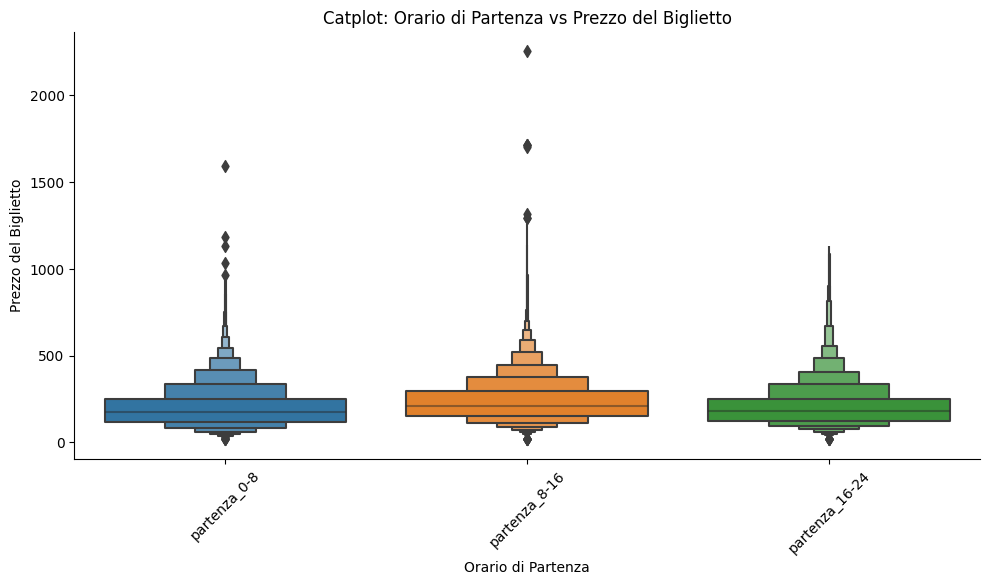

In [46]:
#transform data into "tidy" format
data_tidy = data.melt(id_vars=["prezzo"], value_vars=["partenza_0-8", "partenza_8-16", "partenza_16-24"],
                       value_name="Fascia Oraria", var_name="Orario di Partenza")

#filter data to consider only rows with 1
data_filtered = data_tidy[data_tidy["Fascia Oraria"] == 1]


plt.figure(figsize=(10, 6))
sns.catplot(x="Orario di Partenza", y="prezzo", data=data_filtered, kind="boxen", height=5, aspect=2)
plt.xlabel("Orario di Partenza")
plt.ylabel("Prezzo del Biglietto")
plt.title("Catplot: Orario di Partenza vs Prezzo del Biglietto")
plt.xticks(rotation=45)
plt.show()


In [62]:
def map_numero_giorno(numero_giorno):
    if 24 <= numero_giorno <= 30:
        return 1
    elif numero_giorno==31 or numero_giorno==1 or numero_giorno==2 or numero_giorno==3 or numero_giorno==4 or numero_giorno==5 or numero_giorno==6:
        return 2
    elif 7 <= numero_giorno <= 13:
        return 3
    elif 14 <= numero_giorno <= 20:
        return 4
    else:
        return None

data['giorno_settimana'] = data['data_partenza'].apply(lambda x: x.split()[0])
data['numero_giorno'] = data['data_partenza'].apply(lambda x: int(x.split()[1].split('/')[0]))
data['numero_mese'] = data['data_partenza'].apply(lambda x: int(x.split('/')[1]))

data['colonna_personalizzata'] = data['numero_giorno'].apply(map_numero_giorno)


In [47]:
def map_numero_giorno(numero_giorno):
    if 1 <= numero_giorno <= 6:
        return 1
    #elif numero_giorno==31 or numero_giorno==1 or numero_giorno==2 or numero_giorno==3 or numero_giorno==4 or numero_giorno==5 or numero_giorno==6:
        #return 2
    elif 7 <= numero_giorno <= 13:
        return 2
    elif 14 <= numero_giorno <= 20:
        return 3
    else:
        return None

data['giorno_settimana'] = data['data_partenza'].apply(lambda x: x.split()[0])
data['numero_giorno'] = data['data_partenza'].apply(lambda x: int(x.split()[1].split('/')[0]))
data['numero_mese'] = data['data_partenza'].apply(lambda x: int(x.split('/')[1]))

data['colonna_personalizzata'] = data['numero_giorno'].apply(map_numero_giorno)


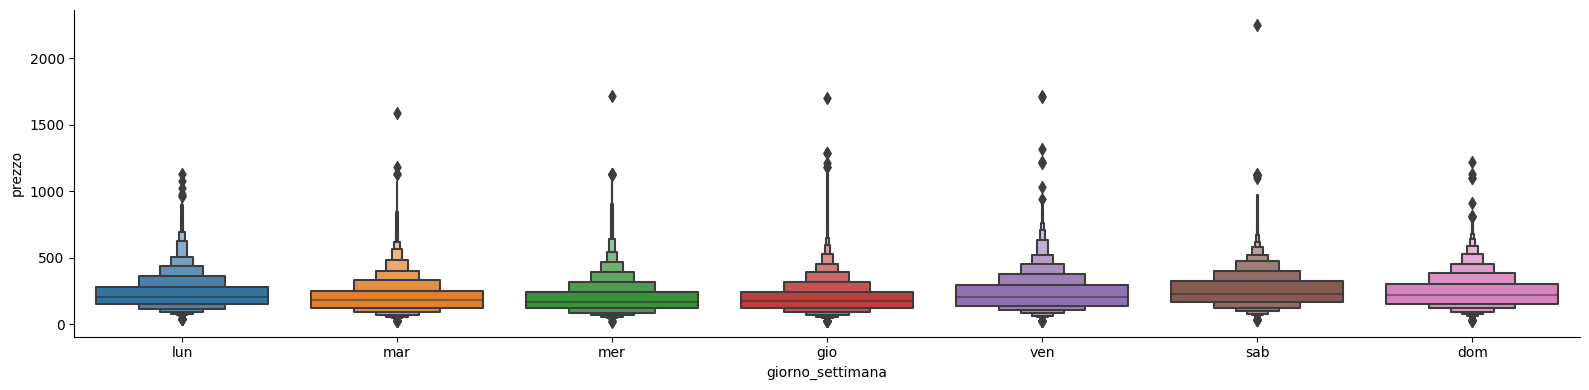

In [48]:
# day of the week vs price, fai anche per il resto
sns.catplot(y = "prezzo", x= "giorno_settimana", data = data.sort_values("prezzo", ascending = False), kind="boxen", height = 4, aspect = 4, order=['lun','mar','mer','gio','ven','sab','dom'])

In [49]:
giorno_settimana_dummy = pd.get_dummies(data['giorno_settimana'])
settimana_dummy = pd.get_dummies(data['colonna_personalizzata'], prefix='settimana')
mese_dummy = pd.get_dummies(data['numero_mese'], prefix='mese')


data = pd.concat([data, giorno_settimana_dummy, settimana_dummy, mese_dummy], axis=1)


data.drop(['giorno_settimana', 'numero_giorno', 'numero_mese', 'colonna_personalizzata'], axis=1, inplace=True)

In [50]:
df = pd.DataFrame(data)
# Funzione per convertire il formato delle date nella colonna 'data_ril'
def converti_data(data):
    giorni_settimana = {'lun': 'Mon', 'mar': 'Tue', 'mer': 'Wed', 'gio': 'Thu', 'ven': 'Fri', 'sab': 'Sat', 'dom': 'Sun'}
    for giorno in giorni_settimana:
        data = data.replace(giorno, giorni_settimana[giorno])

    data = data.replace('\\', '/').replace('\'', '')
    return data

# Funzione per estrarre solo il formato '24/7' dalla colonna 'data_partenza'
def estrai_data_partenza(data):
    return data.split()[1]

# Applica le funzioni alle colonne 'data_partenza' e 'data_ril' del DataFrame 'data'
data['data_partenza'] = data['data_partenza'].apply(estrai_data_partenza)
data['data_ril'] = data['data_ril'].apply(converti_data)

def calculate_date_difference(date_partenza, date_rilevato):
    
    if date_partenza is None or date_rilevato is None:
        return None

    
    date_partenza_obj = datetime.strptime(date_partenza, '%d/%m')
    date_rilevato_obj = datetime.strptime(date_rilevato, '%d/%m')

    
    diff_days = (date_rilevato_obj.replace(year=date_partenza_obj.year) - date_partenza_obj).days

    return abs(diff_days) 

# data['data_partenza'] = data['data_partenza'].apply(format_date_partenza)
# data['data_ril'] = data['data_ril'].apply(format_date_rilevato)


data['differenza_giorni'] = data.apply(lambda row: calculate_date_difference(row['data_partenza'], row['data_ril']), axis=1)

conteggio_celle_vuote = data['differenza_giorni'].isnull().sum()

print("Numero di celle vuote nella colonna 'differenza_giorni':", conteggio_celle_vuote)


Numero di celle vuote nella colonna 'differenza_giorni': 0


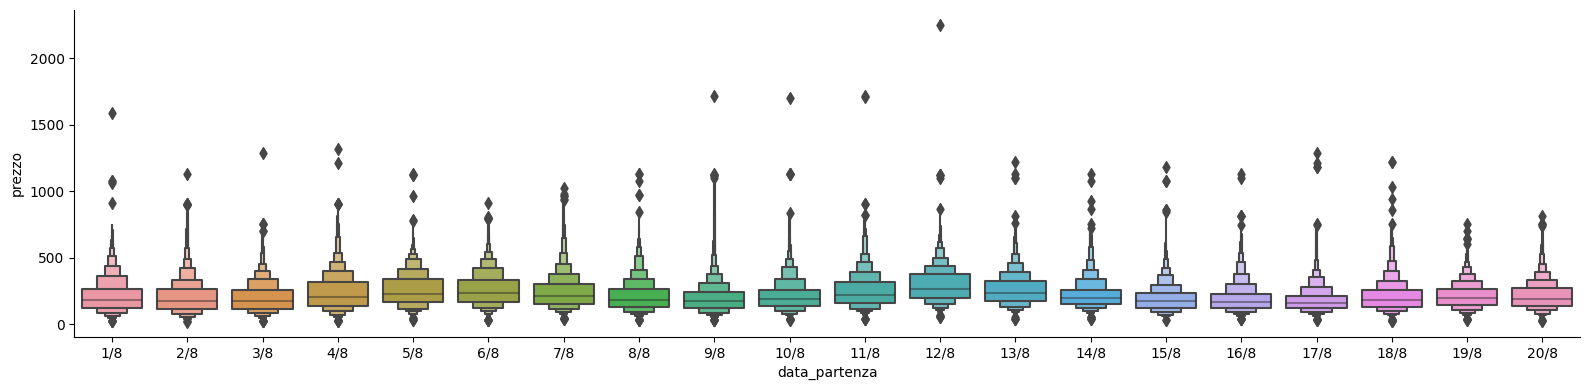

In [51]:
dates = ['1/8', '2/8', '3/8', '4/8','5/8','6/8','7/8','8/8','9/8','10/8','11/8','12/8','13/8','14/8','15/8','16/8','17/8','18/8','19/8','20/8']
sns.catplot(y="prezzo", x='data_partenza', data=data, kind="boxen", height=4, aspect=4, order=dates)


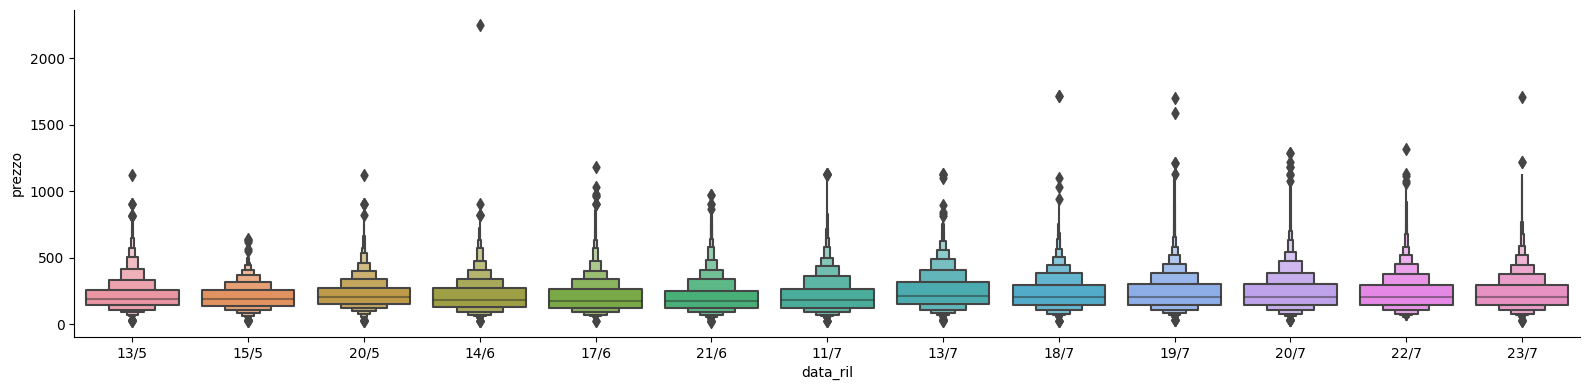

In [52]:
dates = ['13/5', '15/5', '20/5', '14/6','17/6','21/6','11/7','13/7','18/7','19/7','20/7','22/7','23/7']
sns.catplot(y="prezzo", x='data_ril', data=data, kind="boxen", height=4, aspect=4, order=dates)


In [53]:
thresholds = [1, 3, 7, 15, 30, 60]

data['interval'] = pd.cut(data['differenza_giorni'], bins=[0] + thresholds + [float('inf')])

dummy_columns = pd.get_dummies(data['interval'], prefix='Differenza')

data = pd.concat([data, dummy_columns], axis=1)

In [54]:
data = data.drop('orario_partenza', axis=1)
data = data.drop('interval', axis=1)
data = data.drop('orario_arrivo', axis=1)
data = data.drop('data_ril', axis=1)
data = data.drop('data_partenza', axis=1)
data = data.drop('differenza_giorni', axis=1)
output_file = "Voli.xlsx"
#data.to_excel(output_file, index=False)

In [55]:

values_to_remove = ['prezzo','durata','distanza','tipo']
dummy_columns = list(data.columns)
for value in values_to_remove:
    dummy_columns.remove(value)

data[dummy_columns] = data[dummy_columns].applymap(lambda x: 1 if x else 0)


Once we have build our dataset we can start to analyze it further.

Following stesps:
* Outliers removal
* data visualization
* diagnostic 
* features selection

## Outliers removal


In [32]:
data = pd.read_excel('Voli.xlsx')

KeyError: 0

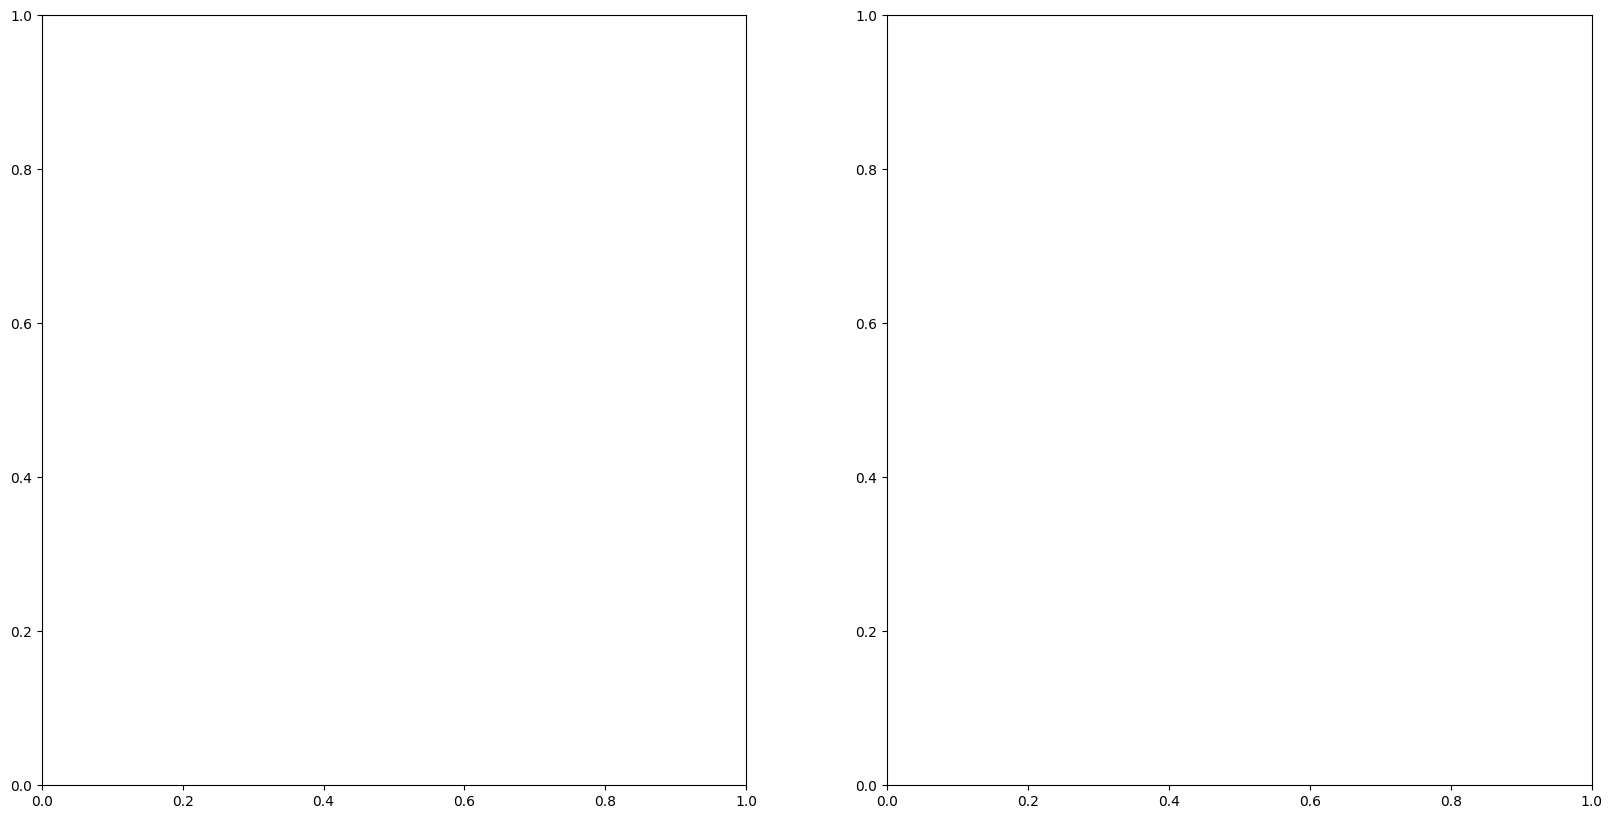

In [87]:
# Box-plots of some principal, non-binary, features. As already seen, on the right side of the plots we notice several outliers
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 10))
features = ['prezzo','durata']
colors = ['b', 'g'] 
for row_idx in range(1):
    k = row_idx
    for col_idx in range(2): 
        current = axes[col_idx]
        target = col_idx + k
        
        if target == 5:
            continue
        
        featureName = features[target]

        sns.boxplot(data.loc[:, featureName], ax = current, color = colors[target])
        

        current.set_title(f"Box plot of data based on {featureName}", fontweight = "bold", fontsize = 22 )
        current.grid()
        
fig.tight_layout()

In [56]:
upper_bound_price = np.percentile(data.loc[:, 'prezzo'], 95)
upper_bound_dimension = np.percentile(data.loc[:, 'durata'], 95)

# We now drop some of the outliers (the 5% with the highest dimensions and prices)

for i in data.index:
    if data.loc[i, 'prezzo'] > upper_bound_price:
        data = data.drop(i)
        continue
    if data.loc[i, 'durata'] > upper_bound_dimension:
        data = data.drop(i)

In [4]:
from sklearn.preprocessing import StandardScaler

columns_to_standardize = ['distanza', 'durata']
scaler = StandardScaler()
data[columns_to_standardize] = scaler.fit_transform(data[columns_to_standardize])


In [8]:
from sklearn.preprocessing import MinMaxScaler

columns_to_normalize = ['distanza', 'durata']
scaler = MinMaxScaler()
data[columns_to_normalize] = scaler.fit_transform(data[columns_to_normalize])


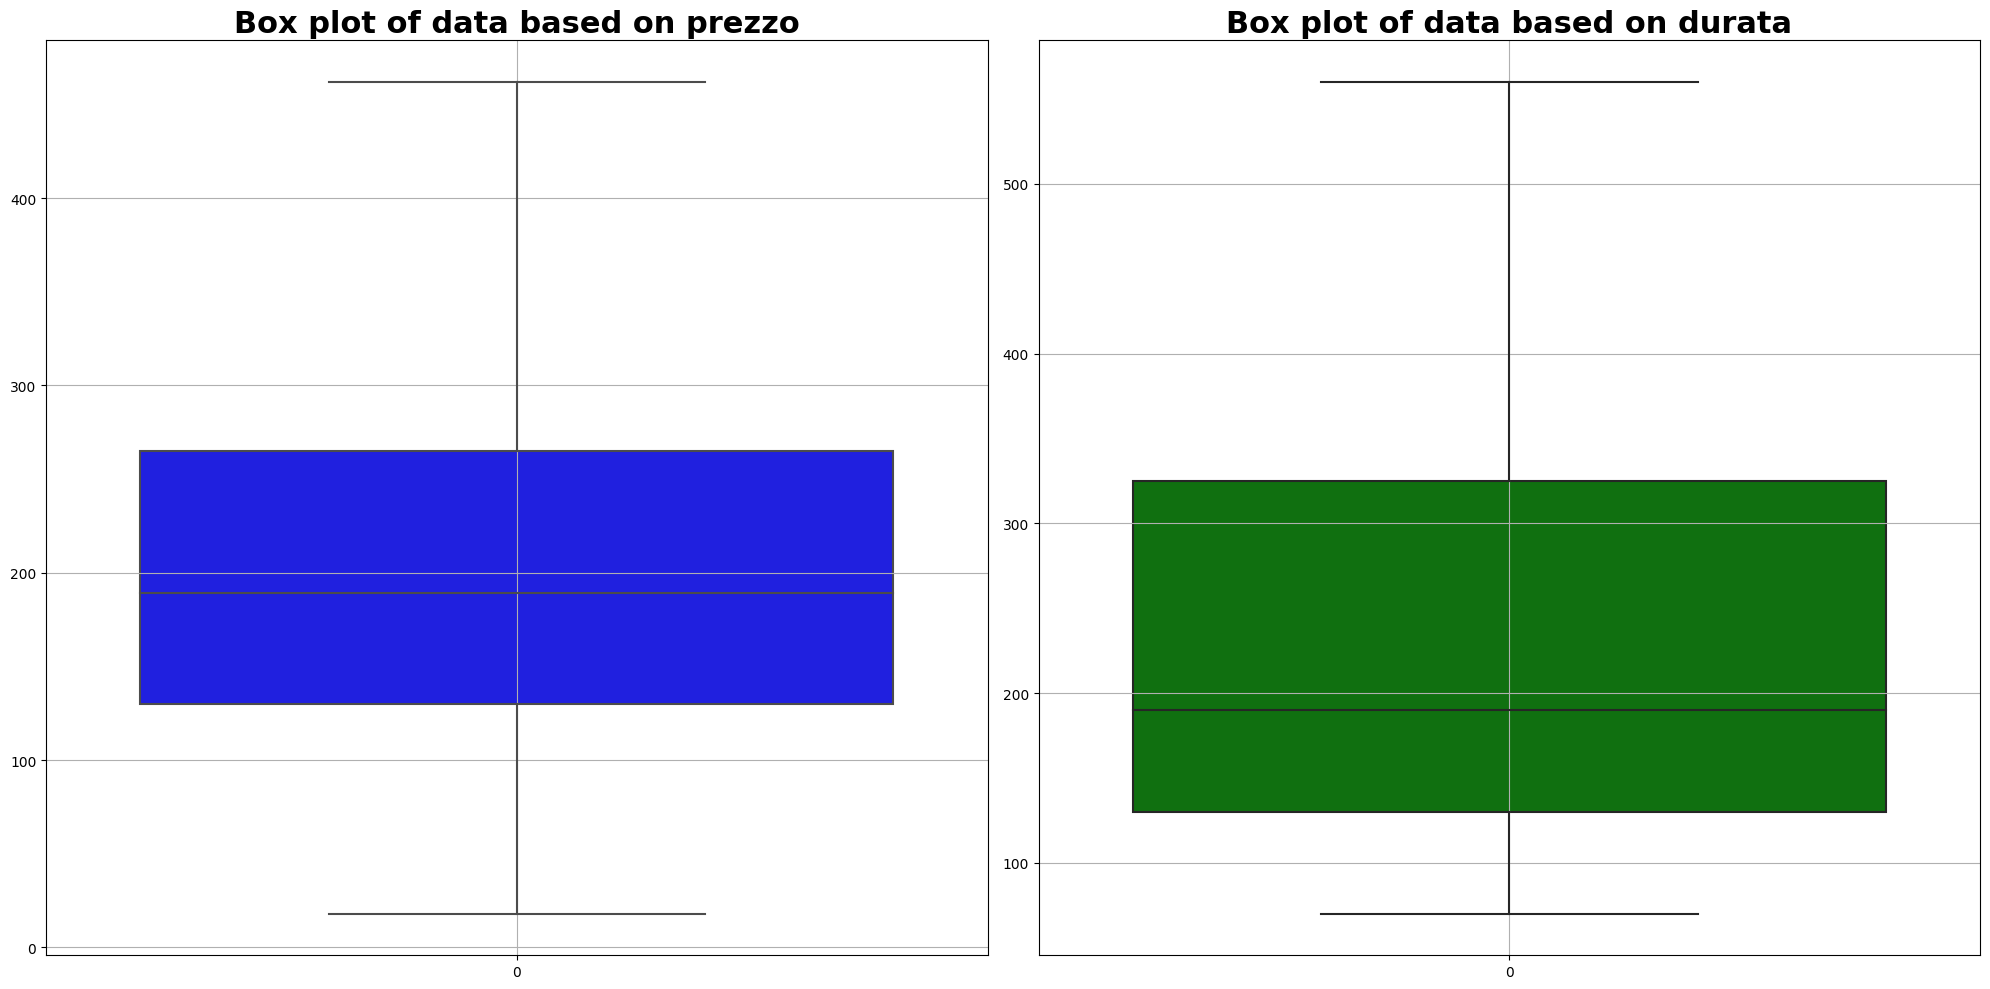

In [49]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 10))
features = ['prezzo','durata']
colors = ['b', 'g'] #['b', 'g', 'm', 'c', 'r']
for row_idx in range(1):
    k = row_idx
    for col_idx in range(2): 
        current = axes[col_idx]
        target = col_idx + k
        
        if target == 5:
            continue
        
        featureName = features[target]

        sns.boxplot(data.loc[:, featureName], ax = current, color = colors[target])
        

        current.set_title(f"Box plot of data based on {featureName}", fontweight = "bold", fontsize = 22 )
        current.grid()
        
fig.tight_layout()

In [10]:
#output_file = "FlightS.xlsx"
#data.to_excel(output_file, index=False)

## Features Selection

In [35]:
import numpy as np
import pandas as pd
from math import isnan
from scipy import stats
import seaborn as sns 
import matplotlib.pyplot as plt
                         

from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, make_scorer

from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, MinMaxScaler
from sklearn.decomposition import PCA, KernelPCA
from sklearn.model_selection import SelectKBest, mutual_info_regression, train_test_split, cross_val_score


In [5]:
data = pd.read_excel('FlightNS.xlsx')

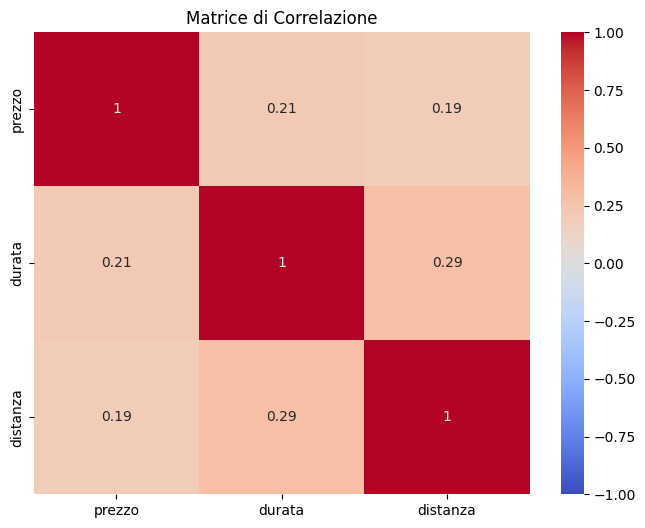

In [50]:
correlation_matrix = data[['prezzo', 'durata', 'distanza']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matrice di Correlazione')
plt.show()

In [4]:
#count the number of occurrencies of each airline
airline_counts = data.loc[:, 'Aegean Airlines':'easyJet'].sum().sort_values(ascending=False)
print(airline_counts)
airline_counts = airline_counts.reset_index()

Multiple_Operator        13464
Vueling                  10425
ITA Airways               7922
Ryanair                   5604
Iberia                    4437
Lufthansa                 2916
KLM                       2878
Wizz Air Malta            2613
easyJet                   2097
Aegean Airlines           1952
Air France                1496
TAP AIR PORTUGAL          1399
Wizz Air                  1242
Sky Express               1227
Transavia                  987
Scandinavian Airlines      986
Air Malta                  949
Norwegian                  819
Hahn Air Systems           771
Volotea                    708
British Airways            693
Eurowings                  670
SWISS                      662
Air Serbia                 360
Austrian Airlines          246
Air Europa                 229
Jet2                       224
airBaltic                  193
Brussels Airlines          173
Finnair                    113
Croatia Airlines            96
Neos Air                    85
Tunisair

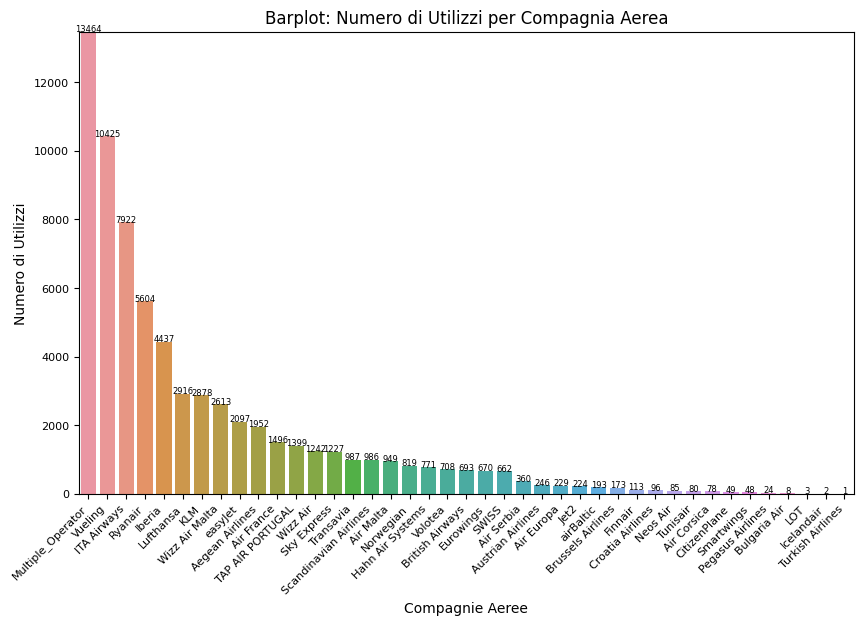

In [5]:
%matplotlib inline
# Creazione del barplot
plt.figure(figsize=(10, 6))
sns.barplot(x='index', y=0, data=airline_counts)

plt.xlabel("Compagnie Aeree")
plt.ylabel("Numero di Utilizzi")

plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(fontsize=8)  
plt.ylim(0, max(airline_counts[0]) + 5)  
for i, v in enumerate(airline_counts[0]):
    plt.text(i, v + 0.5, str(v), ha='center', fontsize=6)  
plt.title("Barplot: Numero di Utilizzi per Compagnia Aerea")
plt.show()

In [56]:

columns_to_drop = ['CitizenPlane', 'Smartwings', 'Pegasus Airlines', 'Bulgaria Air', 'LOT', 'Icelandair', 'Turkish Airlines']

data.drop(columns=columns_to_drop, inplace=True)


In [ ]:
#identify input features X and response y
y = data['prezzo']
 #Load X Variables into a Pandas Dataframe with columns 
copy_data = data.copy()
X = copy_data.drop(['prezzo'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42, test_size=0.3) 

In [9]:
#Chi-square, toglierei
#Perform chi2 test
from sklearn.feature_selection import chi2 
#Calculating Fscore and p value
f_p_values=chi2(X_train,y_train)
#F_p_values
#Representing in list form
p_values=pd.Series(f_p_values[1])
p_values.index=X_train.columns
#P_values        
#Sorting values in ascending order
p_values.sort_index(ascending=False)


tipo                        0.000000e+00
durata                      0.000000e+00
distanza                    0.000000e+00
tariffa_Business            0.000000e+00
tariffa_Economy             1.932205e-90
                               ...      
Differenza_(3.0, 7.0]       2.531193e-88
Differenza_(7.0, 15.0]     1.000362e-108
Differenza_(15.0, 30.0]     1.472094e-55
Differenza_(30.0, 60.0]    2.366610e-107
Differenza_(60.0, inf]     3.939784e-136
Length: 92, dtype: float64

<Axes: >

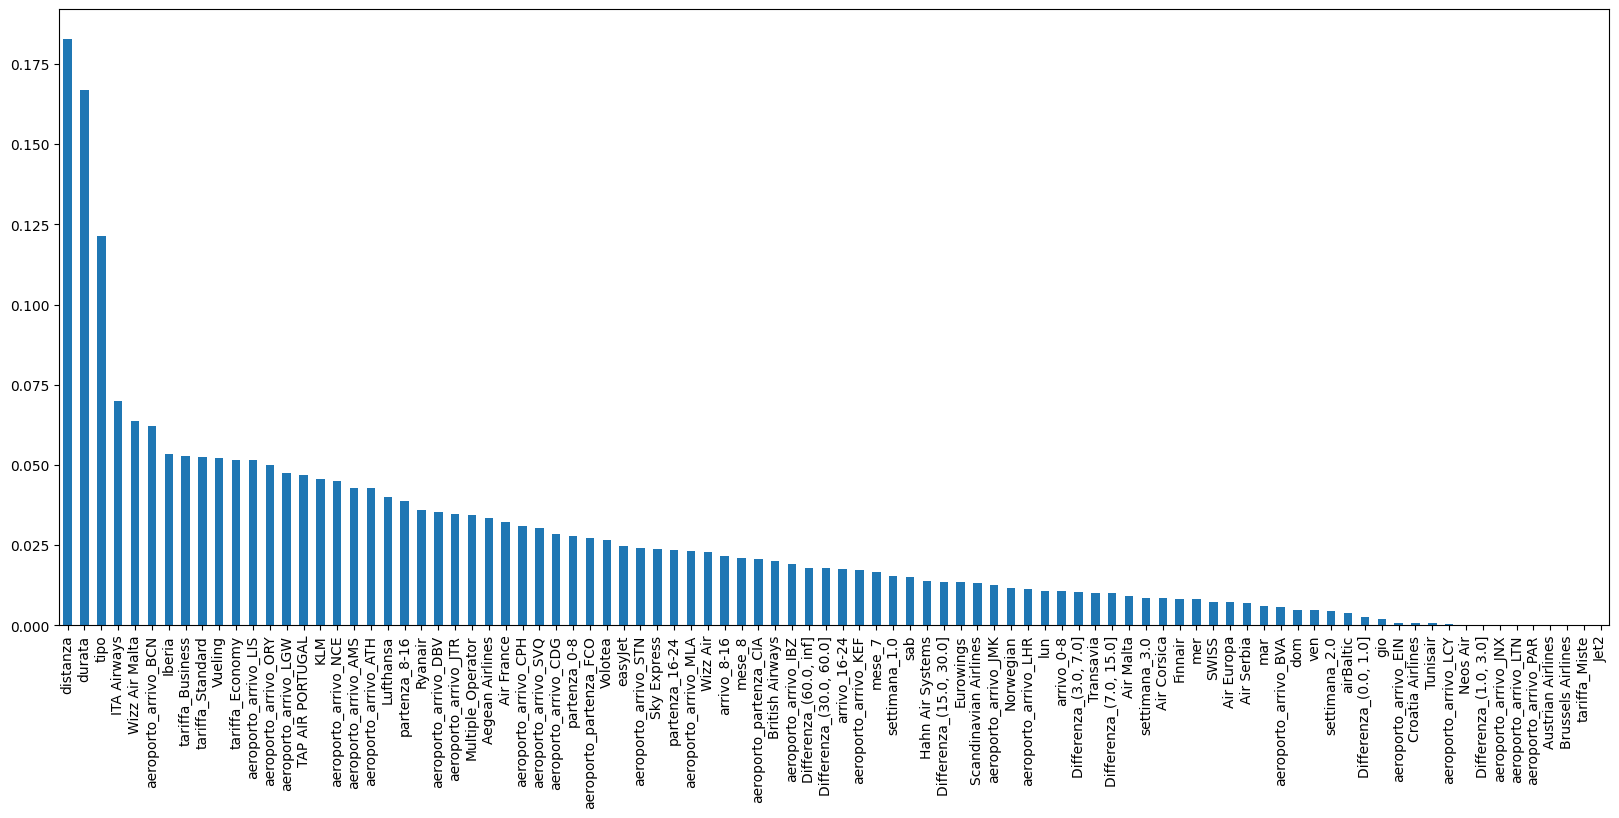

In [15]:
#feature selection by Mutual information gain.ok

# determine the mutual information
mutual_info = mutual_info_classif(X_train, y_train)
mutual_info

mutual_info = pd.Series(mutual_info)
mutual_info.index = X_train.columns
mutual_info.sort_values(ascending=False)

#plot the ordered mutual_info values per feature
mutual_info.sort_values(ascending=False).plot.bar(figsize=(20, 8))

In [16]:
feat = X
price = y

selector = SelectKBest(score_func=mutual_info_regression, k='all')
X_selected = selector.fit_transform(feat, price)

feature_scores = selector.scores_

feature_ranking = sorted(list(zip(feat.columns, feature_scores)), key=lambda x: x[1], reverse=True)

for rank, (feature, score) in enumerate(feature_ranking, start=1):
    print(f"Rank {rank}: Feature '{feature}' - Score: {score}")

# Ottieni gli indici delle prime 80 variabili più importanti
selected_indices = (-X_selected).argsort()[:, :80]

# Seleziona solo le prime 80 variabili
feat_selected = feat.iloc[:, selected_indices[0]]

# Crea un nuovo DataFrame con le prime 80 variabili selezionate
data = pd.concat([feat_selected, price], axis=1)

Rank 1: Feature 'distanza' - Score: 0.1775860033619434
Rank 2: Feature 'durata' - Score: 0.15846227074318353
Rank 3: Feature 'tipo' - Score: 0.11924196389638153
Rank 4: Feature 'ITA Airways' - Score: 0.06375078845284676
Rank 5: Feature 'Wizz Air Malta' - Score: 0.0629001326520573
Rank 6: Feature 'aeroporto_arrivo_BCN' - Score: 0.06227466014324401
Rank 7: Feature 'tariffa_Business' - Score: 0.05582930396578423
Rank 8: Feature 'aeroporto_arrivo_LIS' - Score: 0.05211551312336882
Rank 9: Feature 'tariffa_Standard' - Score: 0.04984530419174282
Rank 10: Feature 'tariffa_Economy' - Score: 0.04885911572032242
Rank 11: Feature 'Vueling' - Score: 0.048629607502779226
Rank 12: Feature 'aeroporto_arrivo_LGW' - Score: 0.04593977995655463
Rank 13: Feature 'TAP AIR PORTUGAL' - Score: 0.04570080776452201
Rank 14: Feature 'Iberia' - Score: 0.04509131194046789
Rank 15: Feature 'aeroporto_arrivo_ORY' - Score: 0.04435547123332739
Rank 16: Feature 'aeroporto_arrivo_ATH' - Score: 0.04425310693719764
Rank 17

In [20]:
from sklearn.feature_selection import SelectKBest, f_regression
feat = X
price = y

selector = SelectKBest(score_func=f_regression, k='all')

X_selected = selector.fit_transform(feat, price)

feature_scores = selector.scores_

feature_ranking = sorted(list(zip(feat.columns, feature_scores)), key=lambda x: x[1], reverse=True)

for rank, (feature, score) in enumerate(feature_ranking, start=1):
    print(f"Rank {rank}: Feature '{feature}' - Score: {score}")


Rank 1: Feature 'tipo' - Score: 4857.017168850091
Rank 2: Feature 'Wizz Air Malta' - Score: 4482.783180393525
Rank 3: Feature 'tariffa_Business' - Score: 3903.895522042415
Rank 4: Feature 'aeroporto_arrivo_ORY' - Score: 3453.37557084524
Rank 5: Feature 'durata' - Score: 3313.7873778037792
Rank 6: Feature 'Lufthansa' - Score: 3084.1287153226
Rank 7: Feature 'Ryanair' - Score: 3066.8650467374846
Rank 8: Feature 'TAP AIR PORTUGAL' - Score: 2988.109073754013
Rank 9: Feature 'Vueling' - Score: 2951.0327114287998
Rank 10: Feature 'aeroporto_arrivo_LGW' - Score: 2866.784683488296
Rank 11: Feature 'aeroporto_arrivo_BCN' - Score: 2658.7219512821116
Rank 12: Feature 'distanza' - Score: 2520.942049034765
Rank 13: Feature 'tariffa_Standard' - Score: 2466.6648532193476
Rank 14: Feature 'aeroporto_arrivo_LIS' - Score: 2400.2961589746674
Rank 15: Feature 'aeroporto_arrivo_KEF' - Score: 2340.7811703512625
Rank 16: Feature 'aeroporto_arrivo_STN' - Score: 2144.8819400519205
Rank 17: Feature 'aeroporto_p

In [21]:

from sklearn.feature_selection import SelectKBest, f_regression

max_features = len(feat.columns)

# Inizializza un modello di regressione lineare
model = LinearRegression()

best_score = 0
best_k = 0

for k in range(1, max_features + 1):
    selector = SelectKBest(score_func=f_regression, k=k)
    X_selected = selector.fit_transform(feat, price)
    
    # Utilizza la cross-validation per valutare le prestazioni del modello
    scores = cross_val_score(model, X_selected, price, cv=5, scoring='neg_mean_squared_error')
    avg_score = -np.mean(scores)
    
    # Aggiorna il miglior punteggio e il miglior numero di features
    if avg_score > best_score:
        best_score = avg_score
        best_k = k

# Seleziona le migliori features utilizzando il miglior numero di features
selector = SelectKBest(score_func=f_regression, k=best_k)
X_selected = selector.fit_transform(feat, price)
selected_features = feat.columns[selector.get_support()]

print(f"Miglior numero di features: {best_k}")
print(f"Migliori features: {selected_features}")


Miglior numero di features: 53
Migliori features: Index(['tipo', 'durata', 'distanza', 'tariffa_Business', 'tariffa_Economy',
       'tariffa_Standard', 'aeroporto_partenza_CIA', 'aeroporto_partenza_FCO',
       'aeroporto_arrivo_AMS', 'aeroporto_arrivo_ATH', 'aeroporto_arrivo_BCN',
       'aeroporto_arrivo_BVA', 'aeroporto_arrivo_CPH', 'aeroporto_arrivo_DBV',
       'aeroporto_arrivo_IBZ', 'aeroporto_arrivo_JMK', 'aeroporto_arrivo_JTR',
       'aeroporto_arrivo_KEF', 'aeroporto_arrivo_LGW', 'aeroporto_arrivo_LIS',
       'aeroporto_arrivo_MLA', 'aeroporto_arrivo_NCE', 'aeroporto_arrivo_ORY',
       'aeroporto_arrivo_STN', 'Aegean Airlines', 'Air France',
       'Austrian Airlines', 'Hahn Air Systems', 'Iberia', 'KLM', 'Lufthansa',
       'Ryanair', 'SWISS', 'Scandinavian Airlines', 'Sky Express',
       'TAP AIR PORTUGAL', 'Volotea', 'Vueling', 'Wizz Air', 'Wizz Air Malta',
       'easyJet', 'partenza_0-8', 'partenza_8-16', 'partenza_16-24',
       'arrivo_0-8', 'arrivo_8-16', 'arrivo

In [18]:
# Checking for Multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
def calc_vif(z):
    # Calculating Variable Inflation Factor (VIF)
    vif = pd.DataFrame()
    vif["variables"] = z.columns
    vif["VIF"] = [variance_inflation_factor(z.values, i) for i in range(z.shape[1])]
    return(vif)

# Compute VIF on X
calc_vif(X)

c:\Users\loren\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,variables,VIF
0,tipo,7.154199
1,durata,6.233468
2,distanza,256.839247
3,tariffa_Business,inf
4,tariffa_Economy,inf
...,...,...
87,"Differenza_(3.0, 7.0]",inf
88,"Differenza_(7.0, 15.0]",inf
89,"Differenza_(15.0, 30.0]",inf
90,"Differenza_(30.0, 60.0]",inf


In [30]:
from sklearn.tree import DecisionTreeRegressor

tree_model = DecisionTreeRegressor() #model initialization
tree_model.fit(feat, price)

feature_importances = tree_model.feature_importances_
selected_features = feat.columns[feature_importances >= 0.0001] #select only those features with a threshold above 0.0001

#Visualize features and their importance
print("Features importance according to regression tree:")
#for feature, importance in zip(feat.columns, feature_importances):
    #print(f"Feature '{feature}': {importance:.4f}")
sorted_features = [feature for _, feature in sorted(zip(feature_importances, feat.columns), reverse=True)]
#print("Importanza delle features ordinate:")
for feature in sorted_features:
    print(f"Feature '{feature}': {feature_importances[feat.columns.get_loc(feature)]:.4f}")

print("Selected features:")
print(selected_features)

num_selected_features = len(selected_features)
print(f"Number of selected features: {num_selected_features}")



NameError: name 'feat' is not defined

With the help of this function, we can select highly correlated features. The purpose is to select the correlated features and then remove them. If you note then we have written abs means absolute, because we will get a negative correlation also which will convert into a positive.

Chi-square is used to find F-score and p-values for all features. So in this case the first array is for F score and the second array is for p- values. Now, what is the importance of these two values? And the more the value of the F score the more important the feature is and the lesser the value of the p-value the more important will be the feature.

mutual_info_classif is a library that is present in feature_selection. It is the property of mutual information gain that the value you will get will never be negative. The higher the value the more important that feature will be or you can say that the dependency of that independent feature will be more on the dependent feature.

## Regression Models

In [4]:
import re
import os
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import statsmodels.api as sm
import xgboost as xgb



from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn import metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, make_scorer
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, cross_val_predict

In [3]:
data=pd.read_excel('datanojulynoout.xlsx', index_col=0)

In [5]:
#identify input features X and response y

y = data.loc[:, 'prezzo'].values.astype('float64') #vector version
yy = data.loc[:, 'prezzo']

XX = data.copy()
XX = XX.drop(['prezzo'], axis = 1)
col_ind = list(XX.columns) #save columns = independent variables

X = XX.values.astype('float64') #matrix version

Divide the dataset in three components: Train, Validation and Test.

In [6]:
# 50% Train - 25% Val - 25% Test --> alleni su train tutti i mod e poi valuti su val 
#poi selezioni modello più promettente e rialleni su (train+val) insieme quindi X_train_part  y_train_part e valuti su test X_test e y_test

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state = 42)

In [7]:
#defining train and test set, using their dataframe version
XX_temp, XX_test, yy_temp, yy_test = train_test_split(XX, yy, test_size = 0.2, random_state = 42)  
XX_train, XX_val, yy_train, yy_val = train_test_split(XX_temp, yy_temp, test_size = 0.25, random_state = 42)

For simplicity we define some evaluation function, in order to return quickly the metrics of the different models.

In [8]:
def model_valid(model, X_train, X_val, y_train = y_train, y_val = y_val):
    print(f'R^2 on train dataset {model.score(X_train, y_train)}')
    print(f'R^2 on validation dataset {model.score(X_val, y_val)}')
    r2_val = model.score(X_val, y_val)
    n_val = len(y_val) # numero delle osservazioni
    p = len(col_ind) #numero colonne
    adjusted_r2_val = 1 - (1 - r2_val) * (n_val - 1) / (n_val - p - 1)
    print("Adjusted R-squared:", adjusted_r2_val)
    mae_val = mean_absolute_error(y_val,model.predict(X_val))
    print("MAE:" , mae_val)
    mse_val = mean_squared_error(y_val,model.predict(X_val))
    print("MSE:" , mse_val)
    rmse_val = mean_squared_error(y_val,model.predict(X_val), squared = False)
    print("RMSE:" , rmse_val)
    return r2_val, rmse_val

In [9]:
def model_eval(model, X_train = X_temp, X_test = X_test, y_train = y_temp, y_test = y_test):
    print(f'R^2 on train dataset {model.score(X_train, y_train)}')
    print(f'R^2 on test dataset {model.score(X_test, y_test)}')
    r2 = model.score(X_test, y_test)
    n = len(y_test) # numero delle osservazioni
    p = len(col_ind) #numero colonne
    adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    print("Adjusted R-squared:", adjusted_r2)
    mae = mean_absolute_error(y_test,model.predict(X_test))
    print("MAE:" , mae)
    mse = mean_squared_error(y_test,model.predict(X_test))
    print("MSE:" , mse)
    rmse = mean_squared_error(y_test,model.predict(X_test), squared = False)
    print("RMSE:" , rmse)
    return  r2, rmse

**Linear Regression**

In [62]:
#start from basic linear regression
lin_reg = LinearRegression()
#fit the model
lin_reg.fit(X_train, y_train)
#make prediction
y_pred_lin = lin_reg.predict(X_val)

#regression coefficients
lin_reg_coef = lin_reg.coef_ 
#print(lin_reg.coef_) 

# evaluation of performance metrics
lin_r2, lin_rmse = model_valid(lin_reg, X_train, X_val)

R^2 on train dataset 0.6008173615530916
R^2 on validation dataset 0.5927619623173697
Adjusted R-squared: 0.5886670179614393
MAE: 46.727002281803834
MSE: 3592.4085154149852
RMSE: 59.936704242183566


**Results visualization**

In order to visualize and evaluate the quality of the results, since we are dealing with a multi-variate regression, is useful to make a two-dimensional plot of points whose coordinates are (y_test , y_hat). 
The more the points will be next to the y = x line, the more the predictor will be precise.

creare un grafico che ti aiuti a visualizzare i risultati della validazione incrociata e a valutare le prestazioni del modello utilizzando Python e librerie come scikit-learn e matplotlib.

La validazione incrociata è una tecnica utilizzata per stimare le prestazioni di un modello su dati non visti durante l'addestramento. Uno dei modi più comuni per farlo è la "K-Fold Cross-Validation", in cui il set di dati viene suddiviso in K parti uguali (fold), il modello viene addestrato su K-1 fold e testato sull'ultimo fold, ripetendo il processo K volte.

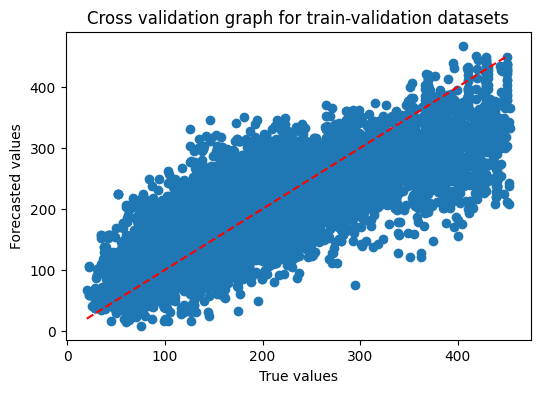

In [63]:
#for train-validation dataset
plt.figure(figsize=(6, 4))
plt.scatter((y_val), (y_pred_lin))

x = np.arange(min((y_val)), max((y_val)))
plt.plot(x, x, '--', c = 'r', label = 'correct forecast')
plt.xlabel("True values")
plt.ylabel("Forecasted values")
plt.title("True values vs Forecasted one")

plt.show()

**Residui Analisys and Q-Q Plot (Quantile-Quantile Plot)**

* catter Plot dei Residui: Questo è un grafico che mostra i residui (differenze tra i valori osservati e i valori predetti dal modello) rispetto ai valori predetti. Se i residui sono distribuiti casualmente intorno allo zero senza un modello evidente, il tuo modello potrebbe essere appropriato.
* Un Q-Q Plot (Quantile-Quantile Plot) è un tipo di grafico utilizzato per confrontare la distribuzione dei quantili di due insiemi di dati. In pratica, viene utilizzato per verificare se due insiemi di dati seguono approssimativamente la stessa distribuzione o se ci sono deviazioni significative. Se i punti sul Q-Q Plot seguono approssimativamente una retta, ciò suggerisce che i dati seguono approssimativamente la distribuzione specificata (nel nostro caso, una distribuzione normale). Se i punti deviano significativamente dalla retta, potrebbe indicare deviazioni dalla distribuzione teorica.

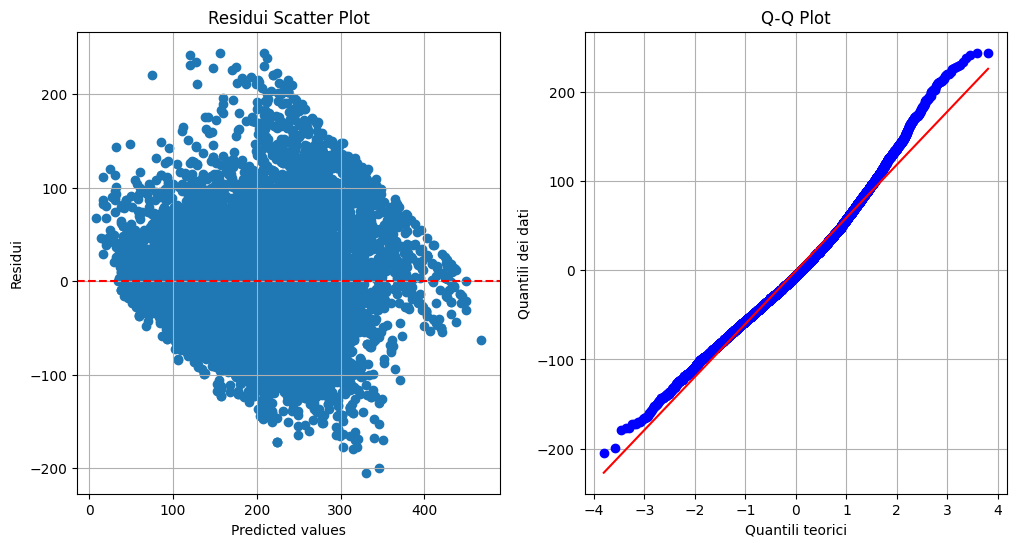

In [64]:

residui = y_val - y_pred_lin # compute residui 

plt.figure(figsize=(12, 6))
# residui scatterplot
plt.subplot(1,2,1)
plt.scatter(y_pred_lin, residui)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Predicted values")
plt.ylabel("Residui")
plt.title("Residui Scatter Plot")
plt.grid(True)
# Creazione del Q-Q Plot
plt.subplot(1,2,2)
stats.probplot(residui, dist="norm", plot=plt)
plt.title("Q-Q Plot")
plt.xlabel("Quantili teorici")
plt.ylabel("Quantili dei dati")
plt.grid(True)
plt.show()

R^2 Scores : [0.23651654 0.58325881 0.58425832 0.46725198 0.41610065 0.4138968
 0.49745537 0.36276905 0.38193252 0.33072508]
R^2 mean value: 0.42741651231141303
RMSE Scores : [64.11010042 63.57455859 56.679644   67.53644748 69.02054297 72.60724776
 55.30520019 71.19335603 58.81165236 75.1478523 ]
RMSE mean value: 65.39866020893442


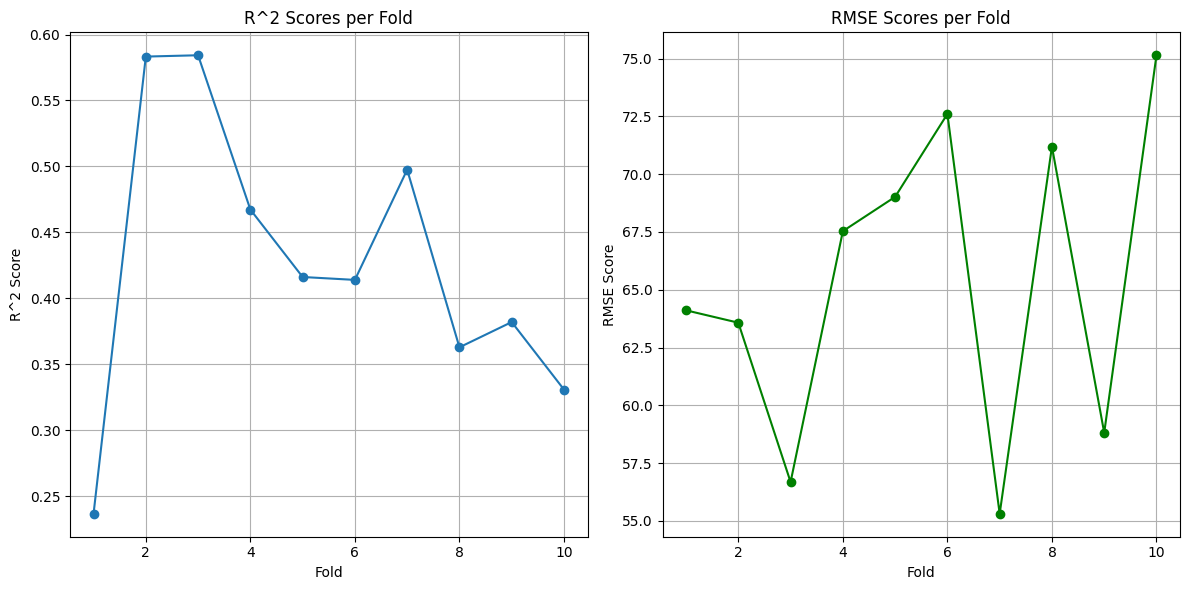

In [65]:
#evualte linear model performance through cross validation on 10 folds
cv_lin_reg = LinearRegression()

#metrics considered r2_score, mean_squared_error
scoring = {
    'r2_score': make_scorer(r2_score),
    'rmse_score': make_scorer(mean_squared_error, squared=False)
}

#cross validation executed evaluating the specified metrics
cv_results = cross_validate(cv_lin_reg, X, y, scoring=scoring, cv=10)

#get values
r2_scores = cv_results['test_r2_score']  #R^2 column
rmse_scores = cv_results['test_rmse_score']  #RMSE column

#results obtained for both metrics
print("R^2 Scores :", r2_scores)
print("R^2 mean value:", np.mean(r2_scores))
print("RMSE Scores :", rmse_scores)
print("RMSE mean value:", np.mean(rmse_scores))
folds = np.arange(1, 11)  # 10 folds

#visualize values of r^2 and RMSE for the different folds
plt.figure(figsize=(12, 6))

# Plot R^2 scores
plt.subplot(1, 2, 1)
plt.plot(folds, r2_scores, marker='o')
plt.title("R^2 Scores per Fold")
plt.xlabel("Fold")
plt.ylabel("R^2 Score")
plt.grid(True)

# Plot RMSE scores
plt.subplot(1, 2, 2)
plt.plot(folds, rmse_scores, marker='o', color='green')
plt.title("RMSE Scores per Fold")
plt.xlabel("Fold")
plt.ylabel("RMSE Score")
plt.grid(True)

plt.tight_layout()
plt.show()


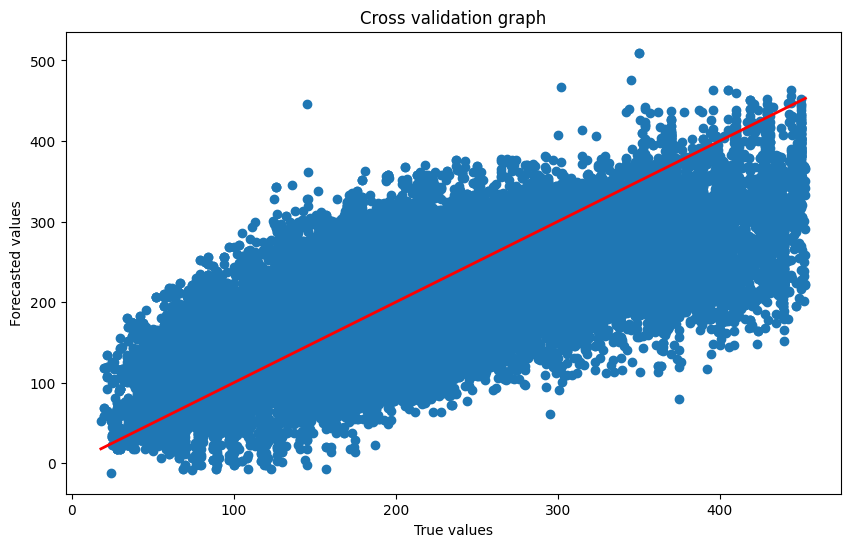

In [66]:
#prediction using crossvalidation
y_pred_cv = cross_val_predict(cv_lin_reg, X, y, cv=10)  

#Plot results
plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred_cv)
plt.plot([min(y), max(y)], [min(y), max(y)], color='red', linewidth=2)  #ideal line
plt.xlabel("True values")
plt.ylabel("Forecasted values")
plt.title("Cross validation graph")
plt.show()


Weak results may be determined by strong multicollinearity problem. Thus we procede with thw implementation of some regularization technique. We are evaluating these further models through cross-validation.

**Ridge and Lasso Regression**

In [81]:
ridge_reg_cv = Ridge(alpha=1.0)  #tentative value
lasso_reg_cv = Lasso(alpha=1.0)  
#we are usinging the RMSE and r^2 to evaluate the models
scoring = {
    'r2_score': make_scorer(r2_score),
    'rmse_score': make_scorer(mean_squared_error, squared=False)
}

#cross-validation
ridge_scores = cross_validate(ridge_reg_cv, X, y, scoring=scoring, cv=10)
lasso_scores = cross_validate(lasso_reg_cv, X, y, scoring=scoring, cv=10)

#Ridge results
ridge_scores_r2 = ridge_scores['test_r2_score']
ridge_scores_rmse = ridge_scores['test_rmse_score']
print(f"R^2 Scores and mean R^2 values are:", ridge_scores_r2, np.mean(ridge_scores_r2))
print(f"RMSE Scores and mean RMSE values are:", ridge_scores_rmse, np.mean(ridge_scores_rmse))
print()
#Lasso results
lasso_scores_r2 = lasso_scores['test_r2_score']
lasso_scores_rmse = lasso_scores['test_rmse_score']
print(f"R^2 Scores and mean R^2 values are:", lasso_scores_r2, np.mean(lasso_scores_r2))
print(f"RMSE Scores and mean RMSE values are:", lasso_scores_rmse, np.mean(lasso_scores_rmse))



R^2 Scores and mean R^2 values are: [0.23612723 0.57731879 0.58548863 0.46774547 0.43240012 0.41338719
 0.49815614 0.36576563 0.37966681 0.51854334] 0.447459934213733
RMSE Scores and mean RMSE values are: [64.12644387 64.02603528 56.5957154  67.50516025 68.05037492 72.63880658
 55.26662702 71.02576555 58.91934933 63.73718803] 64.18914662201936

R^2 Scores and mean R^2 values are: [ 0.0565997   0.3286007   0.59522887  0.22650086  0.226375   -0.01293928
  0.05521965  0.31028287 -0.45768457  0.48407979] 0.18122635781009006
RMSE Scores and mean RMSE values are: [71.26473041 80.69387706 55.92681652 81.37803675 79.44647286 95.45191255
 75.8305275  74.06730486 90.31860325 65.97897563] 77.03572573996931


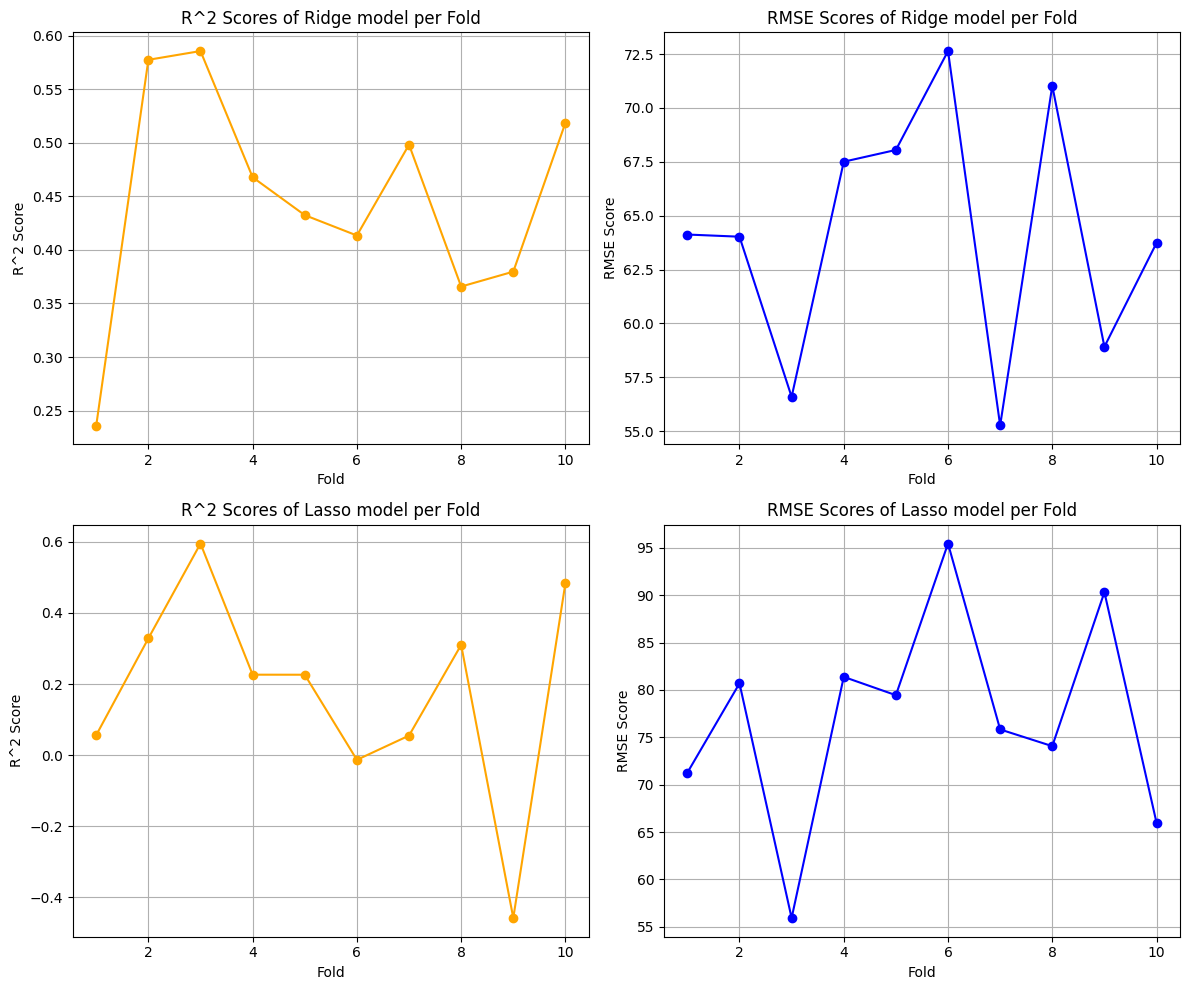

In [82]:
# Visualizza i valori di R^2 e RMSE per i diversi fold per Ridge e Lasso
folds = np.arange(1, 11)  # 10 fold
plt.figure(figsize=(12, 10))  # Aumenta l'altezza per avere spazio per le due righe

# Plot Ridge R^2 scores
plt.subplot(2, 2, 1)  # Prima riga, prima colonna
plt.plot(folds, ridge_scores['test_r2_score'], marker='o', color='orange')
plt.title("R^2 Scores of Ridge model per Fold")
plt.xlabel("Fold")
plt.ylabel("R^2 Score")
plt.grid(True)

# Plot Ridge RMSE scores
plt.subplot(2, 2, 2)  # Prima riga, seconda colonna
plt.plot(folds, ridge_scores['test_rmse_score'], marker='o', color='blue')
plt.title("RMSE Scores of Ridge model per Fold")
plt.xlabel("Fold")
plt.ylabel("RMSE Score")
plt.grid(True)

# Plot Lasso R^2 scores
plt.subplot(2, 2, 3)  # Seconda riga, prima colonna
plt.plot(folds, lasso_scores['test_r2_score'], marker='o', color='orange')
plt.title("R^2 Scores of Lasso model per Fold")
plt.xlabel("Fold")
plt.ylabel("R^2 Score")
plt.grid(True)

# Plot Lasso RMSE scores
plt.subplot(2, 2, 4)  # Seconda riga, seconda colonna
plt.plot(folds, lasso_scores['test_rmse_score'], marker='o', color='blue')
plt.title("RMSE Scores of Lasso model per Fold")
plt.xlabel("Fold")
plt.ylabel("RMSE Score")
plt.grid(True)

plt.tight_layout()
plt.show()


**Lasso Regression (L1 Regolarizzazione):**

La Lasso Regression aggiunge un termine di penalizzazione L1 al termine dell'errore nella funzione obiettivo del modello. Questo termine di penalizzazione è proporzionale alla somma assoluta dei coefficienti del modello, portando alcuni coefficienti a diventare esattamente zero. La Lasso Regression è utile per la selezione delle caratteristiche, eliminando variabili meno rilevanti.

In [69]:
lasso_reg_i = Lasso(alpha=1.0)  
lasso_reg_i.fit(X_train, y_train)
#y_pred_lasso = lasso_reg_i.predict(X_val)

#model evaluation
model_valid(lasso_reg_i, X_train, X_val)

R^2 on train dataset 0.5033935350746666
R^2 on validation dataset 0.501864539639597
Adjusted R-squared: 0.4968555846718852
MAE: 52.650063595047385
MSE: 4394.250792023209
RMSE: 66.2891453559571


(0.501864539639597, 66.2891453559571)

previous results seem to be less promising than the one provided by a simple linear regression. L1 penalty allows implicitly to identify relevant features. In particular the model reduces to zero variables coefficient, thus removing these variables, considered less relevant, from the model itself. However this kind of selection does not always improve the model performance, especially if the removed variables are weakly correlated to the target variable.....

elezione delle Caratteristiche: La regressione Lasso (L1) ha una tendenza a eseguire automaticamente la selezione delle caratteristiche, riducendo i coefficienti di alcune variabili a zero. Ciò significa che Lasso potrebbe eliminare alcune variabili ritenute meno rilevanti. Tuttavia, questa selezione delle caratteristiche potrebbe non sempre portare a miglioramenti significativi nelle prestazioni del modello, specialmente se le variabili eliminate hanno una bassa correlazione con il target.
Bias-Varianza Trade-off: La regressione Lasso tende a ridurre la complessità del modello attraverso la penalizzazione L1. Questo può aiutare a ridurre l'overfitting e migliorare le prestazioni quando ci sono molte variabili. Tuttavia, in alcuni casi, potrebbe anche introdurre un certo grado di bias, riducendo la capacità del modello di adattarsi perfettamente ai dati di addestramento.

**Ridge Regression (L2 Regolarizzazione):**

La Ridge Regression aggiunge un termine di penalizzazione L2 al termine dell'errore nella funzione obiettivo del modello. Questo termine di penalizzazione è proporzionale al quadrato dei coefficienti del modello, riducendo così la magnitudine dei coefficienti. La Ridge Regression è utile quando ci sono molte variabili indipendenti e potrebbe aiutare a prevenire l'overfitting.

In [70]:
ridge_reg_i = Ridge(alpha=1.0)  
ridge_reg_i.fit(X_train, y_train)
#y_pred_ridge = ridge_reg_i.predict(X_val)

#model evaluation
model_valid(ridge_reg_i, X_train, X_val)

R^2 on train dataset 0.6007534082381527
R^2 on validation dataset 0.5925969825724228
Adjusted R-squared: 0.588500379277953
MAE: 46.72782098350719
MSE: 3593.8638672872976
RMSE: 59.94884375271384


(0.5925969825724228, 59.94884375271384)

from previous result we can notice no particular difference from a simple linear regression.

In [84]:
#tuning and try to improve

ridge_reg = Ridge(max_iter=2500)
lasso_reg = Lasso(max_iter=2500)

#possible values of alpha to test
alpha_values = np.logspace(-4, 4, 9) 

#grid search
param_grid_r = {'alpha': alpha_values} 
param_grid_l = {'alpha': alpha_values, 'selection': ['cyclic','random']}

#GridSearchCV for Ridge Regression
scoring = {
    'r2_score': make_scorer(r2_score),
    'rmse_score': make_scorer(mean_squared_error, squared=False, greater_is_better=False)
}
ridge_grid = GridSearchCV(ridge_reg, param_grid_r, cv=10, scoring=scoring, refit = 'rmse_score', n_jobs = -1)
ridge_grid.fit(X_train, y_train)

#GridSearchCV for Lasso Regression
lasso_grid = GridSearchCV(lasso_reg, param_grid_l, cv=10, scoring=scoring, refit = 'rmse_score',  n_jobs = -1)
lasso_grid.fit(X_train, y_train)

#results
print("Optimal value of alpha for Ridge model:", ridge_grid.best_params_)
print("Optimal value of alpha for Lasso model:", lasso_grid.best_params_)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.326e+07, tolerance: 2.354e+04
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.263e+07, tolerance: 2.339e+04
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

Optimal value of alpha for Ridge model: {'alpha': 0.1}
Optimal value of alpha for Lasso model: {'alpha': 0.001, 'selection': 'cyclic'}


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.160e+07, tolerance: 2.606e+04
  model = cd_fast.enet_coordinate_descent(


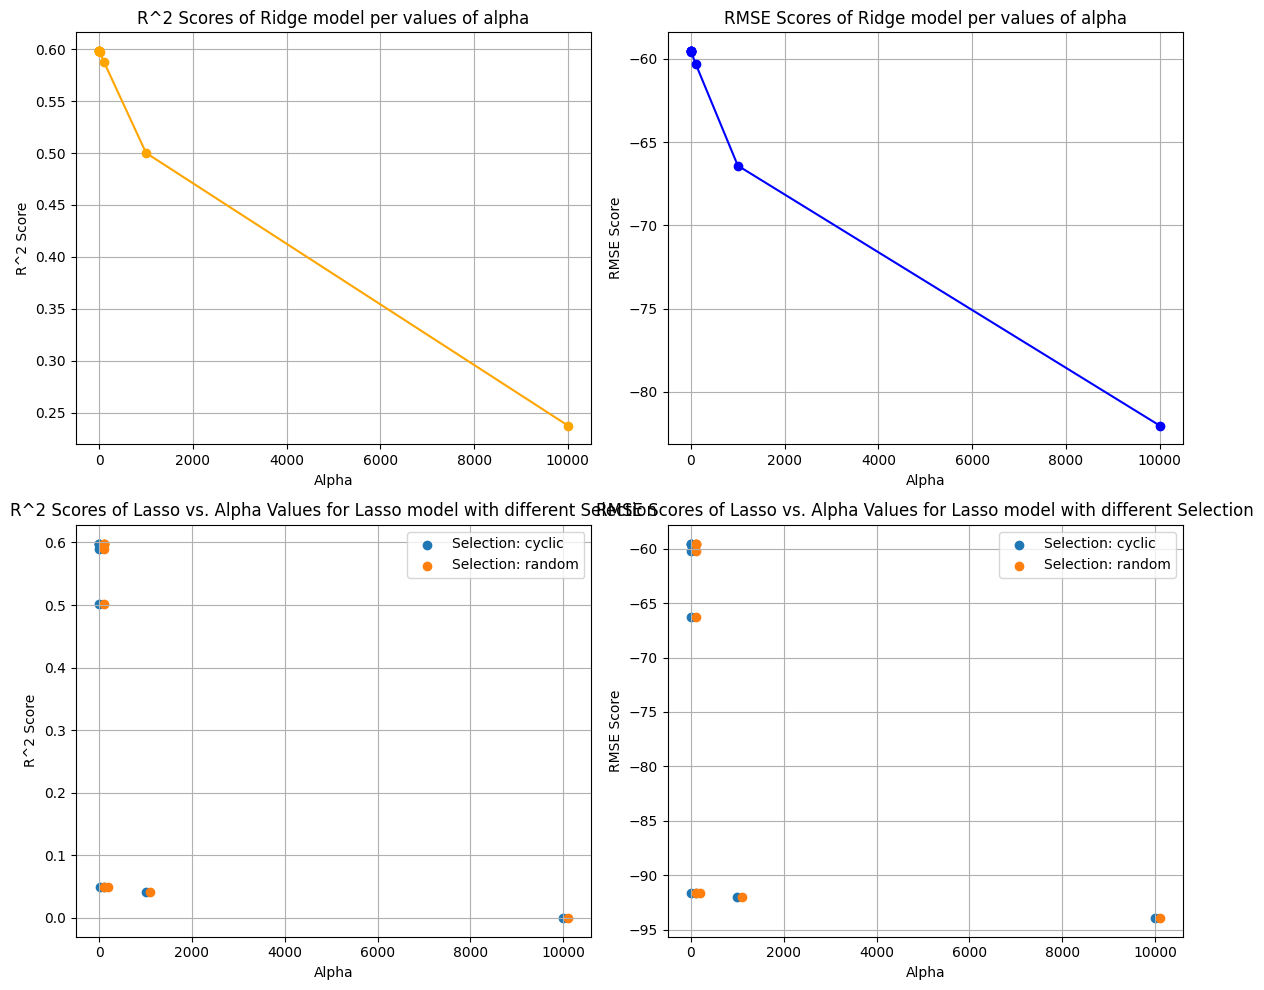

In [85]:

#get the results of GridSearchCV for Ridge
results_ridge = ridge_grid.cv_results_
r2_scores_ridge = results_ridge['mean_test_r2_score'] #test_r2_score
rmse_scores_ridge = results_ridge['mean_test_rmse_score']
alpha_values_r = results_ridge['param_alpha'].data

#get the results of GridSearchCV for Lasso
results_lasso = lasso_grid.cv_results_
r2_scores_lasso = results_lasso['mean_test_r2_score']
rmse_scores_lasso = results_lasso['mean_test_rmse_score']
selection_values = results_lasso['param_selection'].data

alpha_values_l = results_lasso['param_alpha'].data

# Plot Ridge R^2 scores
plt.figure(figsize=(12, 10))
plt.subplot(2,2,1)
plt.plot(alpha_values_r, r2_scores_ridge, marker='o',color='orange')
plt.title("R^2 Scores of Ridge model per values of alpha")
plt.xlabel("Alpha")
plt.ylabel("R^2 Score")
plt.grid(True)

# Plot Ridge RMSE scores
plt.subplot(2,2,2)
plt.plot(alpha_values_r, rmse_scores_ridge, marker='o', color='blue')
plt.title("RMSE Scores of Ridge model per values of alpha")
plt.xlabel("Alpha")
plt.ylabel("RMSE Score")
plt.grid(True)

# Plot Lasso R^2 scores
plt.subplot(2, 2, 3)
for selection_value in set(selection_values):
    selection_indices = [i for i, value in enumerate(selection_values) if value == selection_value]
    alpha_values_selection = alpha_values_l[selection_indices]
    r2_scores_selection_l = r2_scores_lasso[selection_indices]
    #horizontal deviation to "random" data to try to do not overlap with 'cyclyc' data 
    if selection_value == 'random':
        alpha_values_selection += 100
    plt.scatter(alpha_values_selection, r2_scores_selection_l, label=f'Selection: {selection_value}')

plt.xlabel("Alpha")
plt.ylabel("R^2 Score")
plt.title('R^2 Scores of Lasso vs. Alpha Values for Lasso model with different Selection')
plt.legend()
plt.grid(True)


# Plot Lasso RMSE scores
plt.subplot(2, 2, 4) 
for selection_value in set(selection_values):
    selection_indices = [i for i, value in enumerate(selection_values) if value == selection_value]
    alpha_values_selection = alpha_values_l[selection_indices]
    rmse_scores_selection_l = rmse_scores_lasso[selection_indices]
    if selection_value == 'random':
        alpha_values_selection += 100
    plt.scatter(alpha_values_selection, rmse_scores_selection_l, label=f'Selection: {selection_value}')
    
plt.xlabel('Alpha')
plt.ylabel('RMSE Score')
plt.title('RMSE Scores of Lasso vs. Alpha Values for Lasso model with different Selection')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Best estimator

In [86]:
ridge_best = ridge_grid.best_estimator_
y_pred_ridge_best = ridge_best.predict(X_val)
lasso_best = lasso_grid.best_estimator_
y_pred_lasso_best = lasso_best.predict(X_val)

#models evaluation
print('After tuning the parameter alpha, the resulting metrics for Ridge model are: ')
ridge_r2, ridge_rmse = model_valid(ridge_best, X_train, X_val)
print()
print('After tuning the parameter alpha, the resulting metrics for Lasso model are: ')
lasso_r2, lasso_rmse = model_valid(lasso_best, X_train, X_val)

After tuning the parameter alpha, the resulting metrics for Ridge model are: 
R^2 on train dataset 0.6008163151982604
R^2 on validation dataset 0.5927516735502523
Adjusted R-squared: 0.5886566257365774
MAE: 46.726344433690194
MSE: 3592.4992767171866
RMSE: 59.937461380318624

After tuning the parameter alpha, the resulting metrics for Lasso model are: 
R^2 on train dataset 0.6008032837442372
R^2 on validation dataset 0.592783230090743
Adjusted R-squared: 0.5886884995909372
MAE: 46.723454857264194
MSE: 3592.22090393693
RMSE: 59.935139141716604


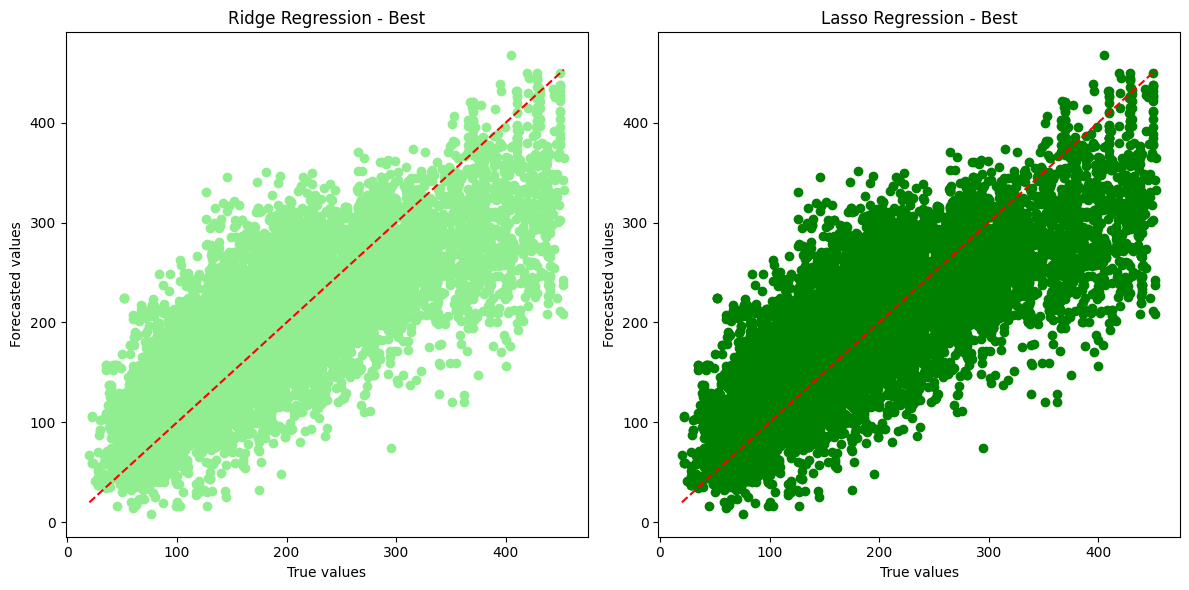

In [87]:
#results plot for Ridge model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(y_val, y_pred_ridge_best, color='lightgreen')
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], linestyle='--', color='red')
plt.title("Ridge Regression - Best")
plt.xlabel("True values")
plt.ylabel("Forecasted values")

#results plot for Lasso model
plt.subplot(1, 2, 2)
plt.scatter(y_val, y_pred_lasso_best, color='green')
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], linestyle='--', color='red')
plt.title("Lasso Regression - Best")
plt.xlabel("True values")
plt.ylabel("Forecasted values")

plt.tight_layout()
plt.show()

Try again, after continuous variable normalization.

In [78]:
columns_to_normalize = ['distanza', 'durata']
scaler = MinMaxScaler()
XX_train[columns_to_normalize] = scaler.fit_transform(XX_train[columns_to_normalize])
XX_val[columns_to_normalize] = scaler.fit_transform(XX_val[columns_to_normalize])

In [79]:
#tuning and try to improve

ridge_reg_2 = Ridge(max_iter=2500)
lasso_reg_2 = Lasso(max_iter=2500)

#possible values of alpha to test
alpha_values = np.logspace(-4, 4, 9) 

#grid search
param_grid_r = {'alpha': alpha_values}
param_grid_l = {'alpha': alpha_values, 'selection': ['cyclic', 'random']}
scoring = {
    'r2_score': make_scorer(r2_score),
    'rmse_score': make_scorer(mean_squared_error, squared=False, greater_is_better=False)
}

#GridSearchCV for Ridge Regression
ridge_grid_2 = GridSearchCV(ridge_reg_2, param_grid_r, cv=5, scoring=scoring, refit = 'rmse_score', n_jobs= -1)
ridge_grid_2.fit(XX_train, yy_train)

#GridSearchCV for Lasso Regression
lasso_grid_2 = GridSearchCV(lasso_reg_2, param_grid_l, cv=5, scoring=scoring, refit = 'rmse_score', n_jobs= -1)
lasso_grid_2.fit(XX_train, yy_train)

#results
print("Optimal value of alpha for Ridge model:", ridge_grid_2.best_params_)
print("Optimal value of alpha for Lasso model:", lasso_grid_2.best_params_)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.854e+07, tolerance: 2.086e+04
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.925e+07, tolerance: 2.097e+04
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

Optimal value of alpha for Ridge model: {'alpha': 0.1}
Optimal value of alpha for Lasso model: {'alpha': 0.001, 'selection': 'cyclic'}


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.243e+06, tolerance: 2.606e+04
  model = cd_fast.enet_coordinate_descent(


In [88]:
ridge_bestn = ridge_grid_2.best_estimator_
y_pred_ridge_bestn = ridge_bestn.predict(XX_val)
lasso_bestn = lasso_grid_2.best_estimator_
y_pred_lasso_bestn = lasso_bestn.predict(XX_val)

#models evaluation
print('Evaluation metrics after normalization of continuous variables for Ridge model:')
model_valid(ridge_bestn, XX_train, XX_val, yy_train, yy_val)
print()
print('Evaluation metrics aafter normalization of continuous variables for Lasso model:')
model_valid(lasso_bestn, XX_train, XX_val, yy_train, yy_val)

Evaluation metrics after normalization of continuous variables for Ridge model:
R^2 on train dataset 0.6008153575778603
R^2 on validation dataset 0.5927425732679508
Adjusted R-squared: 0.5886474339472304
MAE: 46.72634979596987
MSE: 3592.579553922671
RMSE: 59.93813105129881

Evaluation metrics aafter normalization of continuous variables for Lasso model:
R^2 on train dataset 0.6008003058906344
R^2 on validation dataset 0.5927633009802435
Adjusted R-squared: 0.5886683700851136
MAE: 46.72344075434212
MSE: 3592.3967065379593
RMSE: 59.936605730871676


(0.5927633009802435, 59.936605730871676)

No significant improvement has been reached. Thus at this point we can start trying different kind of models, in partciluar non linear one.

**KNN Regression**

In [90]:
#start with simple model, notice that this models performs better in case of standardized data. Thus we are using XX_train, yy_train ecc
k = 5  #neighbors number
knn_model = KNeighborsRegressor(n_neighbors=k)
knn_model.fit(XX_train, yy_train)
y_pred_knn = knn_model.predict(XX_val)
model_valid(knn_model, XX_train, XX_val, yy_train, yy_val)


R^2 on train dataset 0.8762851894739696
R^2 on validation dataset 0.8025534711637939
Adjusted R-squared: 0.800568065887173
MAE: 29.610441848654144
MSE: 1741.7542712036568
RMSE: 41.734329648428


(0.8025534711637939, 41.734329648428)

In [91]:
param_grid_knn = {'n_neighbors': [3, 5, 7, 9, 11, 13],'weights' : ['uniform','distance'],'metric' : ['minkowski','euclidean','manhattan']} #tuning parameters
scoring = {
    'r2_score': make_scorer(r2_score),
    'rmse_score': make_scorer(mean_squared_error, squared=False, greater_is_better=False)
}

grid_knn = GridSearchCV(KNeighborsRegressor(), param_grid_knn, cv=5, scoring =scoring, refit = 'rmse_score', n_jobs=-1) 
grid_knn.fit(XX_train, yy_train)

GridSearchCV(cv=5, estimator=KNeighborsRegressor(), n_jobs=-1,
             param_grid={'metric': ['minkowski', 'euclidean', 'manhattan'],
                         'n_neighbors': [3, 5, 7, 9, 11, 13],
                         'weights': ['uniform', 'distance']},
             refit='rmse_score',
             scoring={'r2_score': make_scorer(r2_score),
                      'rmse_score': make_scorer(mean_squared_error, greater_is_better=False, squared=False)})

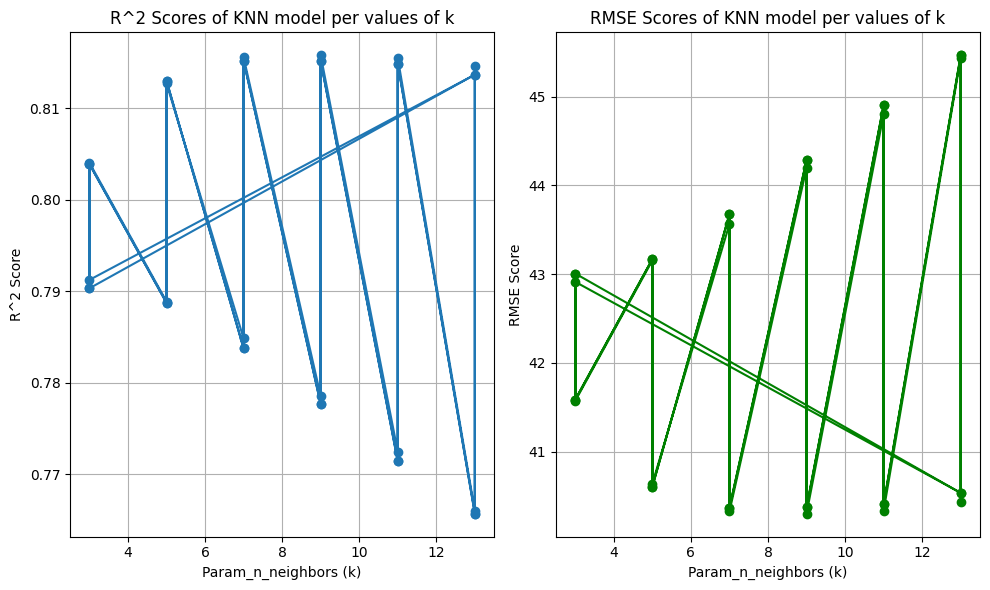

In [90]:
#get the results of GridSearchCV
results_knn = grid_knn.cv_results_
r2_scores_knn = results_knn['mean_test_r2_score']
rmse_scores_knn = -results_knn['mean_test_rmse_score']
k_values = results_knn['param_n_neighbors'].data

# Plot KNN R^2 scores
plt.figure(figsize=(10, 6))
plt.subplot(1,2,1)
plt.plot(k_values, r2_scores_knn, marker='o')
plt.title("R^2 Scores of KNN model per values of k")
plt.xlabel("Param_n_neighbors (k)")
plt.ylabel("R^2 Score")
plt.grid(True)

# Plot KNN RMSE scores
plt.subplot(1,2,2)
plt.plot(k_values, rmse_scores_knn, marker='o', color='green')
plt.title("RMSE Scores of KNN model per values of k")
plt.xlabel("Param_n_neighbors (k)")
plt.ylabel("RMSE Score")
plt.grid(True)

plt.tight_layout()
plt.show()

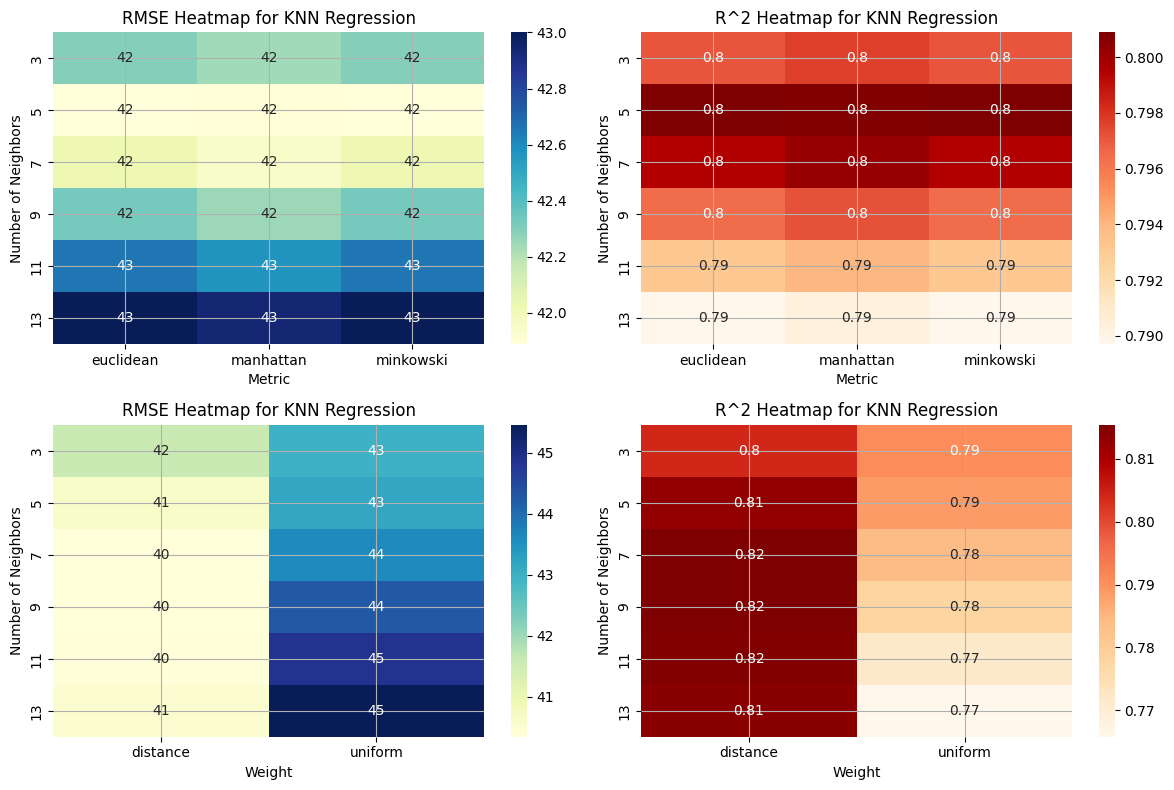

In [91]:

# Creazione di una heatmap per RMSE al variare di n_neighbors e metric
results_knn_df = pd.DataFrame(grid_knn.cv_results_)
pivot_rmse_met = results_knn_df.pivot_table(index='param_n_neighbors', columns='param_metric', values='mean_test_rmse_score')
pivot_r2_met = results_knn_df.pivot_table(index='param_n_neighbors', columns='param_metric', values='mean_test_r2_score')
pivot_rmse_wei = results_knn_df.pivot_table(index='param_n_neighbors', columns='param_weights', values='mean_test_rmse_score')
pivot_r2_wei = results_knn_df.pivot_table(index='param_n_neighbors', columns='param_weights', values='mean_test_r2_score')
plt.figure(figsize=(12, 8))
#Metric
plt.subplot(2,2,1)
sns.heatmap(-pivot_rmse_met, annot=True, cmap='YlGnBu')
plt.xlabel('Metric')
plt.ylabel('Number of Neighbors')
plt.title('RMSE Heatmap for KNN Regression')
plt.grid(True)
plt.subplot(2,2,2)
sns.heatmap(pivot_r2_met, annot=True, cmap='OrRd')
plt.xlabel('Metric')
plt.ylabel('Number of Neighbors')
plt.title('R^2 Heatmap for KNN Regression')
plt.grid(True)
#weight
plt.subplot(2,2,3)
sns.heatmap(-pivot_rmse_wei, annot=True, cmap='YlGnBu')
plt.xlabel('Weight')
plt.ylabel('Number of Neighbors')
plt.title('RMSE Heatmap for KNN Regression')
plt.grid(True)
plt.subplot(2,2,4)
sns.heatmap(pivot_r2_wei, annot=True, cmap='OrRd')
plt.xlabel('Weight')
plt.ylabel('Number of Neighbors')
plt.title('R^2 Heatmap for KNN Regression')
plt.grid(True)
plt.tight_layout()
plt.show()


In [92]:
#best model, mi sembra che questo abbia un valore di validazione un po' inferiore a quello con i dati non normalizzati
knn_best_model = grid_knn.best_estimator_
y_pred_knn = knn_best_model.predict(XX_val)

best_k = grid_knn.best_params_['n_neighbors']
print("Best k:", best_k)
#evaluating results
knn_r2, knn_rmse = model_valid(knn_best_model, XX_train, XX_val, yy_train, yy_val)

Best k: 9
R^2 on train dataset 0.9642900241869031
R^2 on validation dataset 0.8387227361205739
Adjusted R-squared: 0.8371010275365206
MAE: 23.92694318059585
MSE: 1422.6908159173452
RMSE: 37.718573884988615


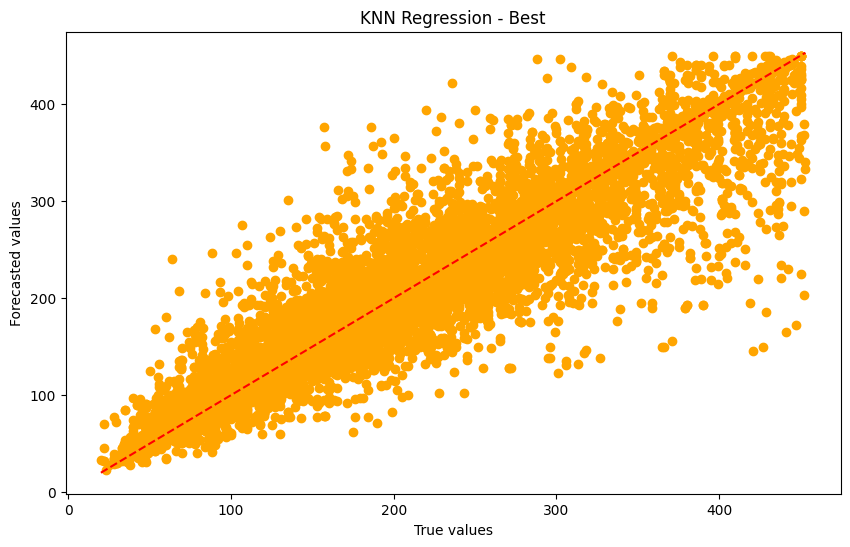

In [93]:
#visualiza results
plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred_knn, color='orange')
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], linestyle='--', color='red')
plt.title("KNN Regression - Best")
plt.xlabel("True values")
plt.ylabel("Forecasted values")
plt.show()

**Gradient Boosting Regression**

In [94]:
#Gradient Boosting
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_val)

#evaluation
model_valid(gb_model, X_train, X_val)

R^2 on train dataset 0.6635436580582859
R^2 on validation dataset 0.6569807854610092
Adjusted R-squared: 0.6535315875311076
MAE: 42.68370936060202
MSE: 3025.9087640068683
RMSE: 55.008260870589865


(0.6569807854610092, 55.008260870589865)

Solving Overfitting Problem

Solving the overfitting problem starts with hyperparameter tuning. We should try different hyperparameters to find the optimum values where the model performs well on both training and testing data. This was a simple model. We have only one hyperparameter here which is the degree in the PolynomialFeatures method. 

__Grid Search for Hyperparameter Tuning__

Sklearn library provides us with functionality to define a grid of parameters and to pick the optimum one. Let us see how that can be used to decide on a proper degree for our prediction.

In [334]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor

# Definisci i parametri che vuoi cercare casualmente
param_dist = {
    'n_estimators': range(300,900,50),  # Numero di alberi
    'learning_rate': np.arange(0.03, 0.25, 0.02),  # Tasso di apprendimento
    'max_depth': range(5,12),  # Massima profondità dell'albero
    'min_samples_split': range(10,100,20),  # Numero minimo di campioni per suddividere un nodo
    'min_samples_leaf': range(10,100,20),  # Numero minimo di campioni in una foglia
    'max_features': [None, 'sqrt', 'log2', 1, 0.5, 0.7]
}

# Definisci le metriche di valutazione++
scoring = {
    'r2_score': make_scorer(r2_score),
    'rmse_score': make_scorer(mean_squared_error, squared=False, greater_is_better=False)
}

# Crea un modello Gradient Boosting
gbr = GradientBoostingRegressor(subsample=0.8, random_state=42) #subsample=0.8,

# Crea un oggetto RandomizedSearchCV
random_search = RandomizedSearchCV(gbr, param_distributions=param_dist, cv=5, scoring=scoring, refit='rmse_score', n_jobs=-1)

# Addestra il modello utilizzando la ricerca casuale dei parametri
random_search.fit(X_train, y_train)

# Ottieni i migliori parametri e il miglior modello
best_params = random_search.best_params_
best_model = random_search.best_estimator_


In [335]:
model_valid(best_model,X_train,X_val)
best_params

R^2 on train dataset 0.9316785601454219
R^2 on validation dataset 0.8704570094281959
Adjusted R-squared: 0.8691544018890992
MAE: 24.038813186092234
MSE: 1142.7501838743913
RMSE: 33.804588207437035


{'n_estimators': 700,
 'min_samples_split': 90,
 'min_samples_leaf': 30,
 'max_features': None,
 'max_depth': 10,
 'learning_rate': 0.21000000000000005}

In [333]:
model_valid(best_model,X_train,X_val)
best_params

R^2 on train dataset 0.9091734263768628
R^2 on validation dataset 0.8623262102628976
Adjusted R-squared: 0.8609418442261403
MAE: 24.95529175980696
MSE: 1214.4751934652447
RMSE: 34.84932127696671


{'n_estimators': 850,
 'min_samples_split': 50,
 'min_samples_leaf': 10,
 'max_features': 0.7,
 'max_depth': 7,
 'learning_rate': 0.13}

In [329]:
model_valid(best_model,X_train,X_val)
best_params

R^2 on train dataset 0.925448675121143
R^2 on validation dataset 0.8677544466899988
Adjusted R-squared: 0.8664246637816897
MAE: 24.332969589786217
MSE: 1166.5905634454887
RMSE: 34.15538849794405


{'n_estimators': 450,
 'min_samples_split': 90,
 'min_samples_leaf': 30,
 'max_features': 0.7,
 'max_depth': 11,
 'learning_rate': 0.19000000000000003}

In [316]:
model_valid(best_model,X_train,X_val)
best_params

R^2 on train dataset 0.9349737512681264
R^2 on validation dataset 0.8726301837699812
Adjusted R-squared: 0.8713494283841263
MAE: 23.712364704982416
MSE: 1123.5797496602008
RMSE: 33.51984113417307


{'n_estimators': 700,
 'min_samples_split': 30,
 'min_samples_leaf': 30,
 'max_features': 0.7,
 'max_depth': 11,
 'learning_rate': 0.15000000000000002}

In [317]:
model_eval(best_model,X_temp,X_test)

R^2 on train dataset 0.9193934662621611
R^2 on test dataset 0.8696058164333414
Adjusted R-squared: 0.8682946498019508
MAE: 23.785028853340602
MSE: 1145.4418831439903
RMSE: 33.84437742290424


(0.8696058164333414, 33.84437742290424)

In [314]:
model_valid(best_model,X_train,X_val)
best_params

R^2 on train dataset 0.9108674275356555
R^2 on validation dataset 0.8617716255054139
Adjusted R-squared: 0.860381682893012
MAE: 25.14604116399968
MSE: 1219.3674059330212
RMSE: 34.91944166124397


{'n_estimators': 400,
 'min_samples_split': 90,
 'min_samples_leaf': 30,
 'max_features': 0.7,
 'max_depth': 9,
 'learning_rate': 0.21000000000000005}

In [312]:
model_valid(best_model,X_train,X_val)
best_params

R^2 on train dataset 0.9178732324691383
R^2 on validation dataset 0.8646460326238841
Adjusted R-squared: 0.8632849933459383
MAE: 24.89138769523412
MSE: 1194.01111881426
RMSE: 34.55446597495409


{'n_estimators': 800,
 'min_samples_split': 70,
 'min_samples_leaf': 90,
 'max_features': None,
 'max_depth': 11,
 'learning_rate': 0.17}

In [278]:
model_valid(best_model,X_train,X_val)
best_params

R^2 on train dataset 0.94201829979658
R^2 on validation dataset 0.874634445527867
Adjusted R-squared: 0.8733738438104168
MAE: 23.252252895488816
MSE: 1105.8993604531381
RMSE: 33.255065184917896


{'n_estimators': 800,
 'min_samples_split': 10,
 'min_samples_leaf': 10,
 'max_features': 0.7,
 'max_depth': 9,
 'learning_rate': 0.13}

In [279]:
model_eval(best_model,X_temp,X_test)

R^2 on train dataset 0.9251782702256672
R^2 on test dataset 0.8732455518227966
Adjusted R-squared: 0.8719709842133809
MAE: 23.168777393688355
MSE: 1113.4687901377968
RMSE: 33.36867977816618


(0.8732455518227966, 33.36867977816618)

In [275]:
model_valid(best_model,X_train,X_val)
best_params

R^2 on train dataset 0.8856221145357903
R^2 on validation dataset 0.8492501258124835
Adjusted R-squared: 0.8477342744200788
MAE: 26.394321035834313
MSE: 1329.8245291885478
RMSE: 36.46675923616668


{'n_estimators': 400,
 'min_samples_split': 50,
 'min_samples_leaf': 10,
 'max_features': 0.7,
 'max_depth': 9,
 'learning_rate': 0.05}

In [276]:
model_eval(best_model,X_temp,X_test)

R^2 on train dataset 0.8765331724713897
R^2 on test dataset 0.8519981161501377
Adjusted R-squared: 0.8505098969199626
MAE: 25.829762615165528
MSE: 1300.1159400578672
RMSE: 36.057120518114964


(0.8519981161501377, 36.057120518114964)

In [273]:
model_valid(best_model,X_train,X_val)
best_params

R^2 on train dataset 0.9187312545530705
R^2 on validation dataset 0.865056308161804
Adjusted R-squared: 0.8636993943715163
MAE: 24.66515702383593
MSE: 1190.3919153025317
RMSE: 34.50205668221145


{'n_estimators': 500,
 'min_samples_split': 30,
 'min_samples_leaf': 30,
 'max_features': 0.5,
 'max_depth': 9,
 'learning_rate': 0.23000000000000004}

In [270]:
model_valid(best_model,X_train,X_val)
best_params

R^2 on train dataset 0.9233475944427084
R^2 on validation dataset 0.8693675564191148
Adjusted R-squared: 0.8680539939862267
MAE: 24.18604309649613
MSE: 1152.3606816786694
RMSE: 33.946438424062535


{'n_estimators': 300,
 'min_samples_split': 10,
 'min_samples_leaf': 10,
 'max_features': 0.7,
 'max_depth': 9,
 'learning_rate': 0.15000000000000002}

In [271]:
model_eval(best_model,X_temp,X_test)

R^2 on train dataset 0.9098576483432664
R^2 on test dataset 0.8680783515627253
Adjusted R-squared: 0.866751825649853
MAE: 24.010384247685536
MSE: 1158.8598300951319
RMSE: 34.04203034625185


(0.8680783515627253, 34.04203034625185)

In [267]:
model_valid(best_model,X_train,X_val)
best_params

R^2 on train dataset 0.9168229605203189
R^2 on validation dataset 0.8652209735852711
Adjusted R-squared: 0.8638657155728923
MAE: 24.78761974014343
MSE: 1188.9393361848647
RMSE: 34.48099964016218


{'n_estimators': 700,
 'min_samples_split': 10,
 'min_samples_leaf': 70,
 'max_features': 0.5,
 'max_depth': 11,
 'learning_rate': 0.19000000000000003}

In [268]:
model_eval(best_model,X_temp,X_test)

R^2 on train dataset 0.9039274056813634
R^2 on test dataset 0.8640367101265717
Adjusted R-squared: 0.86266954386271
MAE: 24.680004231309645
MSE: 1194.3634488225264
RMSE: 34.55956378229514


(0.8640367101265717, 34.55956378229514)

In [264]:
model_valid(best_model,X_train,X_val) #param_dist = {'n_estimators': range(300,900,100), 'learning_rate': np.arange(0.05, 0.25, 0.05), 'max_depth': range(5,12), 'min_samples_sit': range(10,100,20),  'min_samples_leaf': range(10,100,20),  'max_features': [None, 'sqrt', 'log2', 1, 0.5, 0.7]

best_params

R^2 on train dataset 0.918048409286526
R^2 on validation dataset 0.8649333714461818
Adjusted R-squared: 0.8635752214771407
MAE: 24.71030502497385
MSE: 1191.4763889105761
RMSE: 34.517769176332585


{'n_estimators': 500,
 'min_samples_split': 50,
 'min_samples_leaf': 30,
 'max_features': None,
 'max_depth': 9,
 'learning_rate': 0.2}

In [265]:
model_eval(best_model,X_temp,X_test)

R^2 on train dataset 0.9047746990427635
R^2 on test dataset 0.8627596388625883
Adjusted R-squared: 0.8613796311269566
MAE: 24.539890876039653
MSE: 1205.5818243168476
RMSE: 34.721489373539946


(0.8627596388625883, 34.721489373539946)

In [260]:
model_valid(best_model,X_train,X_val) #param_dist = {'n_estimators': range(339,700,100),  # Numero di alberi'learning_rate': np.arange(0.05, 0.25, 0.05),  # Tasso di apprendimento'max_depth': range(5,12),  # Massima profondità dell'albero
    #'min_samples_split': range(10,100,20),  # Numero minimo di campioni per suddividere un nodo
    #'min_samples_leaf': range(10,100,20),  # Numero minimo di campioni in una foglia
    #'max_features': [None, 'sqrt', 'log2', 1, 0.5, 0.7]}

R^2 on train dataset 0.9354896727768454
R^2 on validation dataset 0.8736229729005976
Adjusted R-squared: 0.8723522004138604
MAE: 23.56533652415883
MSE: 1114.8219623298892
RMSE: 33.38894970390487


(0.8736229729005976, 33.38894970390487)

In [259]:
best_params

{'n_estimators': 639,
 'min_samples_split': 70,
 'min_samples_leaf': 10,
 'max_features': 0.7,
 'max_depth': 11,
 'learning_rate': 0.15000000000000002}

In [261]:
model_eval(best_model,X_temp,X_test)

R^2 on train dataset 0.9200285615991756
R^2 on test dataset 0.8726089202628374
Adjusted R-squared: 0.8713279510637566
MAE: 23.44927648254581
MSE: 1119.0612516492095
RMSE: 33.45237288518125


(0.8726089202628374, 33.45237288518125)

In [221]:
grid_search_gb.best_params_

{'max_depth': 10, 'min_samples_split': 80}

In [220]:
model_valid(grid_search_gb.best_estimator_, X_train, X_val)
grid_search_gb.best_params_, grid_search_gb.best_score_

R^2 on train dataset 0.9419217252290075
R^2 on validation dataset 0.8726133735121842
Adjusted R-squared: 0.8713324490923395
MAE: 23.502099223345756
MSE: 1123.7280396225049
RMSE: 33.52205303412225


({'max_depth': 10, 'min_samples_split': 80}, -35.54717328773169)

In [223]:
grid_search_gb.best_estimator_.get_params

<bound method BaseEstimator.get_params of GradientBoostingRegressor(learning_rate=0.18, max_depth=10,
                          min_samples_split=80, n_estimators=600,
                          random_state=42, subsample=0.8)>

In [222]:
model_eval(grid_search_gb.best_estimator_, X_temp, X_test)

R^2 on train dataset 0.9246007247786151
R^2 on test dataset 0.8718929211678782
Adjusted R-squared: 0.8706047523062377
MAE: 23.363269739768633
MSE: 1125.3509137278886
RMSE: 33.546250367632574


(0.8718929211678782, 33.546250367632574)

In [250]:
gb_2 = GradientBoostingRegressor(learning_rate=0.18, max_depth=10, max_features=17, min_samples_leaf=20 ,min_samples_split=80, n_estimators=600,random_state=42, subsample=0.8)
gb_2.fit(X_train,y_train)
model_valid(gb_2,X_train,X_val)

R^2 on train dataset 0.9142410321175664
R^2 on validation dataset 0.8629154602585081
Adjusted R-squared: 0.8615370193704857
MAE: 24.930568981613032
MSE: 1209.2771851603593
RMSE: 34.7746629769486


(0.8629154602585081, 34.7746629769486)

In [341]:

gb_grid = GradientBoostingRegressor(subsample=0.8, random_state=42)

param_grid = {
    'n_estimators': [450, 500, 600, 700, 800],
    'learning_rate': [0.13, 0.15, 0.18, 0.20],
    'max_depth': [8,9,10],
    'min_samples_split': [10,30,50,80],
    'min_samples_leaf': [10,30,50],
    'max_features':[None, 0.5, 0.7],
    
}
scoring = {
    'r2_score': make_scorer(r2_score),
    'rmse_score': make_scorer(mean_squared_error, squared=False, greater_is_better=False)
}

grid_search_gb = GridSearchCV(gb_grid, param_grid, cv=3, scoring=scoring, refit= 'rmse_score', n_jobs=-1)
grid_search_gb.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:

results_gb = pd.DataFrame(grid_search_gb.cv_results_)

r2_scores = results_gb['mean_test_r2_score']
rmse_scores = -results_gb['mean_test_rmse_score']

heatmap_data = results_gb[['param_learning_rate', 'param_n_estimators', 'mean_test_r2_score']]

# Trasforma il DataFrame in una matrice pivot
heatmap_data = heatmap_data.pivot('param_learning_rate', 'param_n_estimators', 'mean_test_r2_score')

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='viridis')
plt.title('R^2 Score Heatmap for Learning Rate and N Estimators')
plt.xlabel('N Estimators')
plt.ylabel('Learning Rate')
plt.show()


In [ ]:
#param_max_depth = results_gb['param_max_depth']
#min_samples_split_values = results_gb['param_min_samples_split']
#min_samples_leaf_values = results_gb['param_min_samples_leaf']

# Creazione dei grafici
plt.figure(figsize=(15, 12))

# Grafico R^2 vs. max_depth
plt.subplot(3, 1, 1)
sns.lineplot(x='param_max_depth', y='mean_test_r2_score', data=results_gb, marker='o')
plt.xlabel('Max Depth')
plt.ylabel('R^2 Score')
plt.title('R^2 Scores vs. Max Depth')

# Grafico R^2 vs. min_samples_split
plt.subplot(3, 1, 2)
sns.lineplot(x='param_min_samples_split', y='mean_test_r2_score', data=results_gb, marker='o')
plt.xlabel('Min Samples Split')
plt.ylabel('R^2 Score')
plt.title('R^2 Scores vs. Min Samples Split')

# Grafico R^2 vs. min_samples_leaf
plt.subplot(3, 1, 3)
sns.lineplot(x='param_min_samples_leaf', y='mean_test_r2_score', data=results_gb, marker='o')
plt.xlabel('Min Samples Leaf')
plt.ylabel('R^2 Score')
plt.title('R^2 Scores vs. Min Samples Leaf')

plt.tight_layout()
plt.show()

In [96]:
# Predizione
optimized_gb_model = grid_search_gb.best_estimator_
y_pred_gb_best = optimized_gb_model.predict(X_val)

#tuned model results
gb_r2, gb_rmse = model_valid(optimized_gb_model,X_train,X_val)

R^2 on train dataset 0.8458694073479065
R^2 on validation dataset 0.8156515794404888
Adjusted R-squared: 0.8137978809780599
MAE: 29.678126128779777
MSE: 1626.210654559241
RMSE: 40.326302267369385


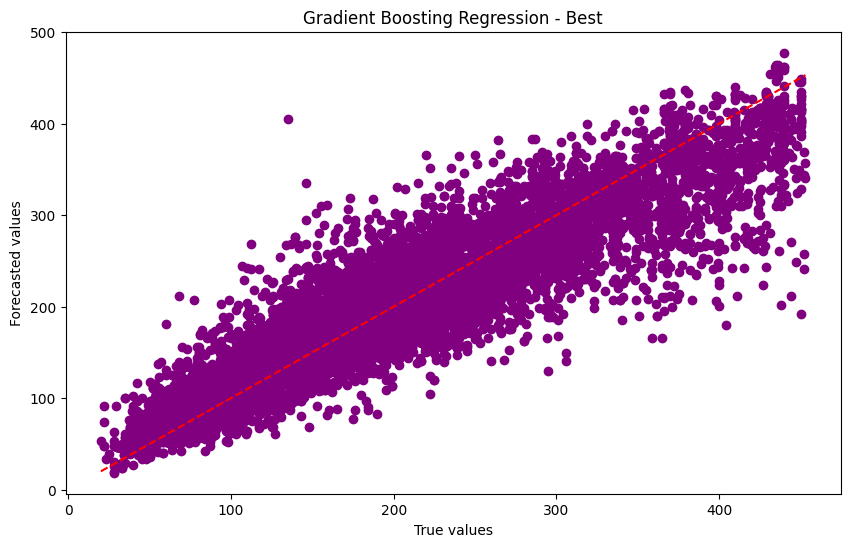

In [97]:
#visualiza results
plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred_gb_best, color='purple')
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], linestyle='--', color='red')
plt.title("Gradient Boosting Regression - Best")
plt.xlabel("True values")
plt.ylabel("Forecasted values")
plt.show()

**XGBoost Regression**

In [218]:
xgb_reg_rand_2 = xgb.XGBRegressor(n_estimators = 500, learning_rate=0.18, max_depth=7, subsample=0.8, colsample_bytree=0.8,random_state=42)
xgb_reg_rand_2.fit(X_train,y_train)
model_valid(xgb_reg_rand_2, X_train,X_val)

R^2 on train dataset 0.9357714342492983
R^2 on validation dataset 0.8715205431067196
Adjusted R-squared: 0.8702286298319872
MAE: 23.696646014901816
MSE: 1133.368330782033
RMSE: 33.6655362467618


(0.8715205431067196, 33.6655362467618)

In [219]:
model_eval(xgb_reg_rand_2,X_temp,X_val)

R^2 on train dataset 0.9197144612821684
R^2 on test dataset -0.9014886922309695
Adjusted R-squared: -0.9206089355963127
MAE: 103.15741513389328
MSE: 16703.54251110143
RMSE: 129.24218549336524


(-0.9014886922309695, 129.24218549336524)

In [20]:
#Gridsearch narrowed 
param_grid_xgb_refined = {
    'n_estimators': [425, 450, 475],
    'learning_rate': [0.15,0.18,0.2],
    'max_depth': [6,7],
    'subsample': [0.80, 0.82, 0.84, 0.86],
    'colsample_bytree': [0.80, 0.82, 0.84]
}

scoring = {
    'r2_score': make_scorer(r2_score),
    'rmse_score': make_scorer(mean_squared_error, squared=False, greater_is_better=False)
}
xgb_reg_rand_2 = xgb.XGBRegressor(random_state=42)
random_search_2 = RandomizedSearchCV(xgb_reg_rand_2, param_distributions=param_grid_xgb_refined, cv=5, scoring=scoring, refit='rmse_score', n_jobs=-1)
random_search_2.fit(X_train, y_train)

best_params_rand_xgb_2 = random_search_2.best_params_
best_model_rand_xgb_2 = random_search_2.best_estimator_

**Random Forest Regression**

In [37]:
#base model 

rf_reg = RandomForestRegressor()
rf_reg.fit(X_train, y_train)
y_pred_rf = rf_reg.predict(X_val)

#model evaluation results
print('Random Forest Regression evaluation metrics:')
model_valid(rf_reg, X_train, X_val, y_train, y_val)

print('Normalized RMSE ', round(np.sqrt(metrics.mean_squared_error(y_val, y_pred_rf)))/(max(y_val)-min(y_val)),2)
# RMSE/(max(DV)-min(DV))
#print('Max Value: ', max(y), '\nMin Value: ', min(y))


Random Forest Regression evaluation metrics:
R^2 on train dataset 0.9555687471914291
R^2 on validation dataset 0.8707016804672962
Adjusted R-squared: 0.8694015331951636
MAE: 22.573562720085995
MSE: 1140.591843437086
RMSE: 33.77264933991833
Normalized RMSE  0.07852193995381063 2


Since the number of possible parameters to tune is quite large as well as the dimension of the dataset, the idea is to perform, initially, the parameters tuning with Random Forest Regressor in order to try a wide range of possibilities. At the end of this procedure, on a smaller and selected set of parameters, we are going to apply the GridSearch procedure to identify the optimal parameters for our Random Forest model.

In [255]:
#start tuning parameters for random forest
rfc_i = RandomForestRegressor(random_state=42)
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 5, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = [1, 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
#min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
#min_samples_leaf = [1, 2, 4]
min_samples_split = [2, 5, 10, 20]
min_samples_leaf = [1, 2, 5, 10]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
scoring = {
    'r2_score': make_scorer(r2_score),
    'rmse_score': make_scorer(mean_squared_error, squared=False, greater_is_better=False)
}
rcv = RandomizedSearchCV(rfc_i, random_grid, verbose=1, scoring=scoring, refit='rmse_score', n_jobs=-1)
rcv.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RandomizedSearchCV(estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': [1, 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 20],
                                        'n_estimators': [5, 115, 226, 336, 447,
                                                         557, 668, 778, 889,
                                                         1000]},
                   refit='rmse_score',
                   scoring={'r2_score': make_scorer(r2_score),
                            'rmse_score': make_scorer(mean_squared_error, greater_is_better=False, squared=False)},
                   verbose=1)

In [186]:
print(rcv.best_params_)

{'n_estimators': 557, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 60, 'bootstrap': False}


In [185]:
#verify if there is an improvement with respect to the base model #first execution
#print(rcv.best_params_)
best_random = rcv.best_estimator_
model_valid(best_random, X_train, X_val)

R^2 on train dataset 0.9239061919829001
R^2 on validation dataset 0.8505180151105209
Adjusted R-squared: 0.849352281780649
MAE: 26.724784124514922
MSE: 1426.9250770226506
RMSE: 37.77466183862737


In [39]:
#verify if there is an improvement with respect to the base model #second execution
print(rcv.best_params_)
best_random = rcv.best_estimator_
model_valid(best_random, X_train, X_val)

{'n_estimators': 447, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 60, 'bootstrap': False}
R^2 on train dataset 0.9166786732749662
R^2 on validation dataset 0.8538348819746853
Adjusted R-squared: 0.8523651321730763
MAE: 25.86443818714365
MSE: 1289.3805736781087
RMSE: 35.90794582927445


(0.8538348819746853, 35.90794582927445)

Since we have better results after tuning paramteres, according to the parameters identified by random search grid we can...implement a gridsearch more narrow down etc

In [44]:
# Create the parameter grid based on the results of random search 
param_grid_rf = {
    'bootstrap': [False],
    'max_depth': [50, 60, 70, 80, 90],
    'max_features': ['sqrt'],
    'min_samples_leaf': [1, 2, 3, 4],
    'min_samples_split': [3, 5, 8],
    'n_estimators': [450, 500, 550, 600, 650]
}
scoring = {
    'r2_score': make_scorer(r2_score),
    'rmse_score': make_scorer(mean_squared_error, squared=False,  greater_is_better=False)
}
# Create a based model
rf = RandomForestRegressor(random_state=42)
# Instantiate the grid search model
grid_search_rf = GridSearchCV(estimator = rf, param_grid = param_grid_rf, 
                          cv = 3, scoring=scoring, n_jobs = -1, refit='rmse_score') 

In [45]:
# Fit the grid search to the data
grid_search_rf.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [False],
                         'max_depth': [50, 60, 70, 80, 90],
                         'max_features': ['sqrt'],
                         'min_samples_leaf': [1, 2, 3, 4],
                         'min_samples_split': [3, 5, 8],
                         'n_estimators': [450, 500, 550, 600, 650]},
             refit='rmse_score',
             scoring={'r2_score': make_scorer(r2_score),
                      'rmse_score': make_scorer(mean_squared_error, greater_is_better=False, squared=False)})

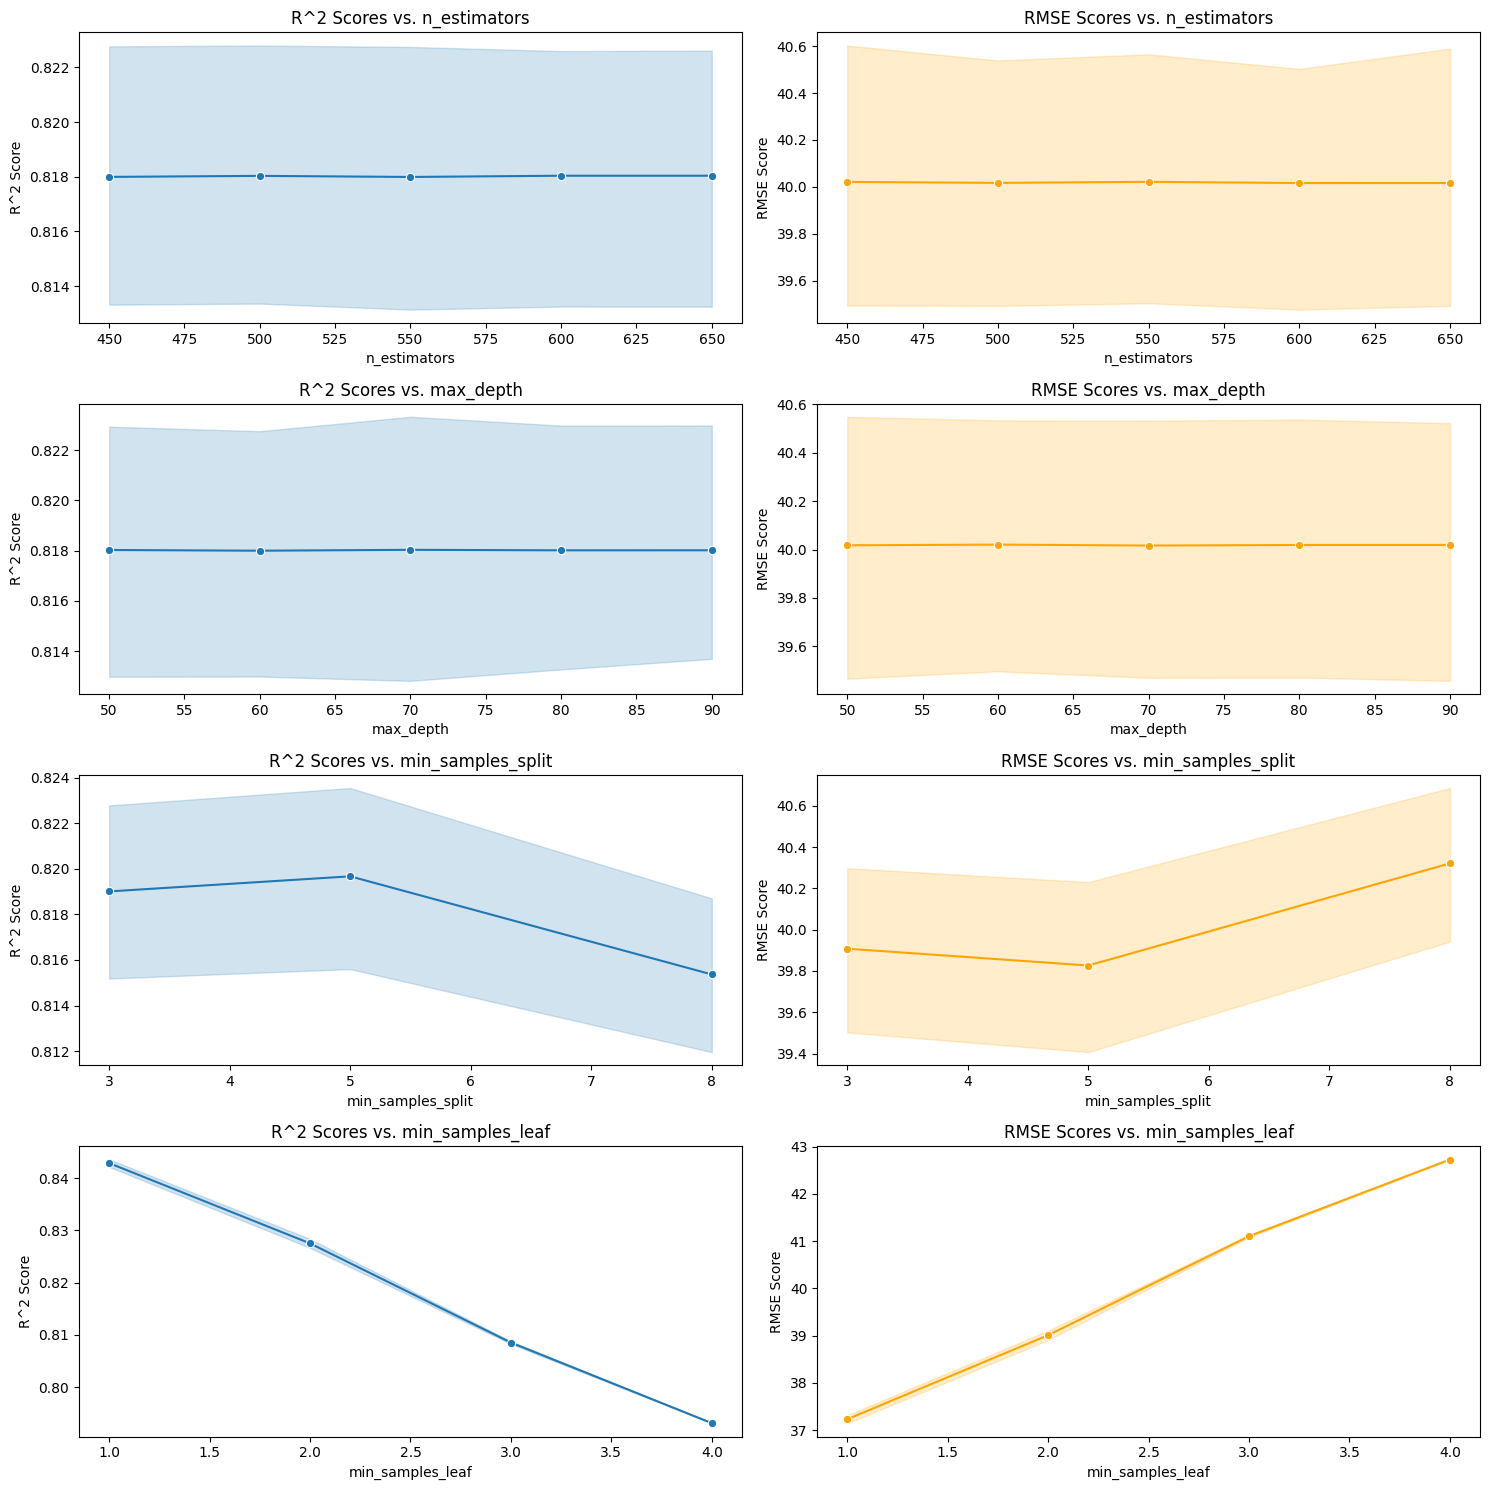

In [183]:
# Estrazione dei risultati dalla GridSearchCV
results_rf = pd.DataFrame(grid_search_rf.cv_results_)
n_estimators_values = results_rf['param_n_estimators']
max_depth_values = results_rf['param_max_depth']
min_samples_split_values = results_rf['param_min_samples_split']
min_samples_leaf_values = results_rf['param_min_samples_leaf']
r2_scores = results_rf['mean_test_r2_score']
rmse_scores = -results_rf['mean_test_rmse_score']
# Iperparametri da valutare
param_names = ['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf']
param_values = [n_estimators_values, max_depth_values, min_samples_split_values, min_samples_leaf_values]

# Creazione dei grafici
plt.figure(figsize=(15, 15))
for i, param_name in enumerate(param_names):
    plt.subplot(4, 2, i*2 + 1)
    sns.lineplot(x=param_values[i], y=r2_scores, marker='o')
    plt.xlabel(param_name)
    plt.ylabel('R^2 Score')
    plt.title(f'R^2 Scores vs. {param_name}')
    
    plt.subplot(4, 2, i*2 + 2)
    sns.lineplot(x=param_values[i], y=rmse_scores, marker='o', color='orange')
    plt.xlabel(param_name)
    plt.ylabel('RMSE Score')
    plt.title(f'RMSE Scores vs. {param_name}')

plt.tight_layout()
plt.show()


In [48]:
#best model
grid_search_rf.best_params_
best_grid_rf = grid_search_rf.best_estimator_
y_pred_rf_best = grid_search_rf.predict(X_val)
rf_r2, rf_rmse = model_valid(best_grid_rf, X_train, X_val)

R^2 on train dataset 0.9512792602097421
R^2 on validation dataset 0.8672517630524789
Adjusted R-squared: 0.8659169254554281
MAE: 23.34502374779836
MSE: 1171.0249355151075
RMSE: 34.22024160515392


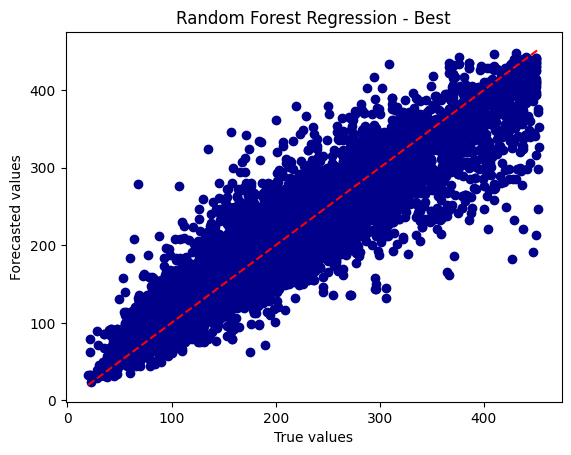

In [58]:
# Plot performance graph
plt.scatter(y_val, y_pred_rf_best, color='darkblue')
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], linestyle='--', color='red')
plt.title("Random Forest Regression - Best")
plt.xlabel("True values")
plt.ylabel("Forecasted values")
plt.show()

**MODEL COMPARISON**

Barplot

In [59]:
# Definisci i modelli, i punteggi RMSE e R^2
models = ['Linear Regression', 'Ridge', 'Lasso', 'KNN', 'Gradient Boosting', 'Random Forest']
rmse_scores = [lin_rmse, ridge_rmse, lasso_rmse, knn_rmse, gb_rmse, rf_rmse]
r2_scores = [lin_r2, ridge_r2, lasso_r2, knn_r2, gb_r2, rf_r2]

# Definisci i colori per ciascun modello
#colors map
colors = plt.colormaps['tab20c']

# Creazione del primo subplot per RMSE
plt.figure(figsize=(8, 10))
plt.subplot(2, 1, 1)
for i, model in enumerate(models):
    plt.bar(model, rmse_scores[i], color=colors(i), label=model)
plt.ylabel('RMSE Score')
plt.title('Comparison of RMSE Scores for Regression Models')
plt.legend()

# Creazione del secondo subplot per R^2
plt.subplot(2, 1, 2)
for i, model in enumerate(models):
    plt.bar(model, r2_scores[i], color=colors(i), label=model)
plt.ylabel('R^2 Score')
plt.title('Comparison of R^2 Scores for Regression Models')
plt.legend()

# Aggiustamento dello spaziamento tra i subplot
plt.tight_layout()

# Mostra i grafici
plt.show()


NameError: name 'ridge_rmse' is not defined

Comparison table

In [244]:
models = ['Linear Regression', 'Ridge', 'Lasso', 'KNN', 'Gradient Boosting', 'Random Forest'] #, 'XGBoost', 'Random Forest'
results = pd.DataFrame({
    'Model': models,
    'RMSE': [lin_rmse, ridge_rmse, lasso_rmse, knn_rmse, gb_rmse, rf_rmse],
    'R^2': [lin_r2, ridge_r2, lasso_r2, knn_r2, gb_r2, rf_r2] 
})

print(results)

               Model       RMSE       R^2
0  Linear Regression  59.936704  0.592762
1              Ridge  59.937461  0.592752
2              Lasso  59.935139  0.592783
3  Gradient Boosting  40.316185  0.815744


Grafico a dispersione: Puoi creare un grafico a dispersione che mostri il confronto tra le predizioni effettuate dai modelli e i valori reali. Questo ti darà un'idea visiva di quanto bene i modelli si avvicinano ai valori reali.

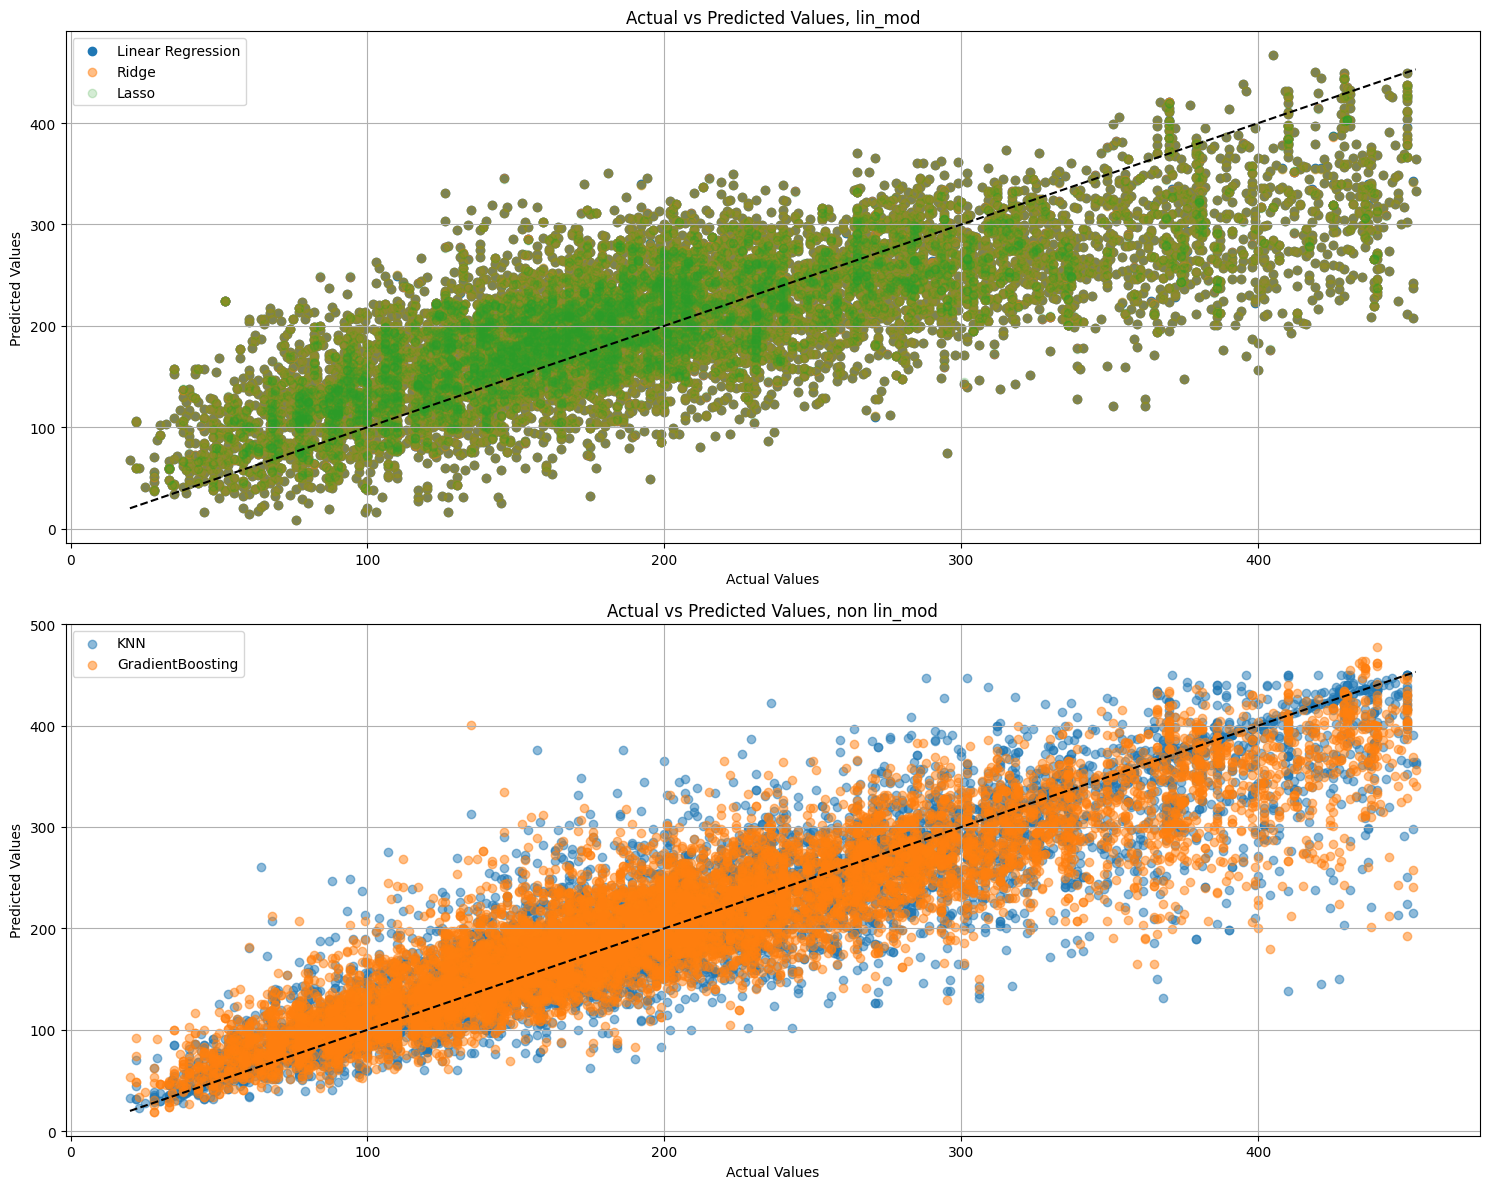

In [265]:
#linear models
plt.figure(figsize=(15, 12))
plt.subplot(2,1,1)
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], linestyle='--', color='black')
plt.scatter(y_val, y_pred_lin, label='Linear Regression')
plt.scatter(y_val, y_pred_ridge_best, label='Ridge', alpha=0.5)
plt.scatter(y_val, y_pred_lasso_best, label='Lasso', alpha=0.2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values, lin_mod')
plt.legend()
plt.grid(True)
#non linear models
plt.subplot(2,1,2)
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], linestyle='--', color='black')
plt.scatter(y_val, y_pred_knn, label='KNN', alpha=0.5)
plt.scatter(y_val, y_pred_gb_best, label='GradientBoosting', alpha=0.5)
plt.scatter(y_val, y_pred_rf_best, label='RandomForest', alpha=0.5)
# Aggiungi altri modelli
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values, non lin_mod')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


conclusion part test dataset

In [133]:
#Again start with a base model also for final test part

rf_i_te = RandomForestRegressor()
rf_i_te.fit(X_temp, y_temp)
y_pred_rfi_te = rf_i_te.predict(X_test)

#model evaluation results
print('Random Forest Regression evaluation metrics:')
model_eval(rf_i_te, X_temp, X_test, y_temp, y_test)



Random Forest Regression evaluation metrics:
R^2 on train dataset 0.952400581786264
R^2 on test dataset 0.8771088457308182
Adjusted R-squared: 0.8758731251153472
MAE: 21.709139151496252
MSE: 1079.531857307655
RMSE: 32.85623011405379


In [309]:
#start tuning parameters for random forest model, once we have choosen a smaller set of values with them we are going to apply gridSearch
rfc = RandomForestRegressor(random_state=42)
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 5, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = [1, 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
#min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
#min_samples_leaf = [1, 2, 4]
min_samples_split = [2, 5, 10, 20]
min_samples_leaf = [1, 2, 5, 10]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
scoring = {
    'r2_score': make_scorer(r2_score),
    'rmse_score': make_scorer(mean_squared_error, squared=False, greater_is_better=False)
}
rcv_te = RandomizedSearchCV(rfc, random_grid, n_iter=50, scoring=scoring, refit='rmse_score', n_jobs=-1)
rcv_te.fit(X_temp,y_temp)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RandomizedSearchCV(estimator=RandomForestRegressor(random_state=42), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': [1, 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 20],
                                        'n_estimators': [5, 115, 226, 336, 447,
                                                         557, 668, 778, 889,
                                                         1000]},
                   refit='rmse_score',
                   scoring={'r2_score': make_scorer(r2_score),
                            'rmse_score': make_scorer(mean_squared_error, greater_is_better=False, squared=False)})

In [310]:
print(rcv_te.best_params_) #7
model_eval(rcv_te.best_estimator_, X_temp,X_test)

{'n_estimators': 668, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 90, 'bootstrap': True}
R^2 on train dataset 0.9321386018641824
R^2 on test dataset 0.8720471544646337
Adjusted R-squared: 0.8707605364816184
MAE: 23.3764303054095
MSE: 1123.9960582194083
RMSE: 33.52605044169993


(0.8720471544646337, 33.52605044169993)

In [308]:
print(rcv_te.best_params_) #6
model_eval(rcv_te.best_estimator_, X_temp,X_test)

{'n_estimators': 336, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 80, 'bootstrap': True}
R^2 on train dataset 0.9522437660591977
R^2 on test dataset 0.8761659281419882
Adjusted R-squared: 0.8749207261060673
MAE: 22.094402508819936
MSE: 1087.8148747633138
RMSE: 32.98203866899852


(0.8761659281419882, 32.98203866899852)

In [306]:
print(rcv_te.best_params_) #5
model_eval(rcv_te.best_estimator_, X_temp,X_test)

{'n_estimators': 447, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 100, 'bootstrap': True}
R^2 on train dataset 0.9522682559061779
R^2 on test dataset 0.8764477573983652
Adjusted R-squared: 0.8752053892704194
MAE: 22.076850766612097
MSE: 1085.339158244988
RMSE: 32.94448600668992


(0.8764477573983652, 32.94448600668992)

In [291]:
print(rcv_te.best_params_) #4
model_eval(rcv_te.best_estimator_, X_temp,X_test)

{'n_estimators': 668, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 60, 'bootstrap': False}
R^2 on train dataset 0.950114453764171
R^2 on test dataset 0.8769161025810647
Adjusted R-squared: 0.8756784438547097
MAE: 22.10433091804066
MSE: 1081.2250009002441
RMSE: 32.881985963445764


(0.8769161025810647, 32.881985963445764)

In [288]:
print(rcv_te.best_params_) #3
model_eval(rcv_te.best_estimator_, X_temp,X_test)

{'n_estimators': 668, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 90, 'bootstrap': False}
R^2 on train dataset 0.950114453764171
R^2 on test dataset 0.8769161025810647
Adjusted R-squared: 0.8756784438547097
MAE: 22.10433091804066
MSE: 1081.2250009002441
RMSE: 32.881985963445764


(0.8769161025810647, 32.881985963445764)

In [286]:
print(rcv_te.best_params_) #2
model_eval(rcv_te.best_estimator_, X_temp,X_test)

{'n_estimators': 557, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 40, 'bootstrap': False}
R^2 on train dataset 0.9228761992799701
R^2 on test dataset 0.8647397170012936
Adjusted R-squared: 0.8633796197579247
MAE: 24.31543265244984
MSE: 1188.1879163223903
RMSE: 34.47010177418092


(0.8647397170012936, 34.47010177418092)

In [283]:
print(rcv_te.best_params_) #1

{'n_estimators': 336, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 100, 'bootstrap': False}


In [284]:
model_eval(rcv_te.best_estimator_, X_temp,X_test) #1

R^2 on train dataset 0.9589766125302825
R^2 on test dataset 0.873017988228819
Adjusted R-squared: 0.8717411323747686
MAE: 21.647654115633898
MSE: 1115.4678123678602
RMSE: 33.398619917114246


(0.873017988228819, 33.398619917114246)

In [296]:
# Create the parameter grid based on the results of random search --> da rivedere in base ai valori della random
param_grid_rf_test = {
    'max_depth': [40, 60, 80, 90, 100],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [2, 3, 5, 6],
    'n_estimators': [450, 550, 600, 650, 680]
}
scoring = {
    'r2_score': make_scorer(r2_score),
    'rmse_score': make_scorer(mean_squared_error, squared=False, greater_is_better=False)
}
# Create a based model
rf = RandomForestRegressor(max_features = 'sqrt', bootstrap = False, random_state=42)
# Instantiate the grid search model
grid_rf_test = GridSearchCV(estimator = rf, param_grid = param_grid_rf_test, cv = 3, scoring=scoring, refit = 'rmse_score', n_jobs = -1) 

In [297]:
grid_rf_test.fit(X_temp, y_temp) # Fit the grid search to the data

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=3,
             estimator=RandomForestRegressor(bootstrap=False,
                                             max_features='sqrt',
                                             random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [50, 60, 70, 80, 90],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 5, 6],
                         'n_estimators': [400, 550, 600, 650, 700]},
             refit='rmse_score',
             scoring={'r2_score': make_scorer(r2_score),
                      'rmse_score': make_scorer(mean_squared_error, greater_is_better=False, squared=False)})

In [299]:
grid_rf_test.best_params_

{'max_depth': 60,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 700}

In [298]:
#best model
best_rf = grid_rf_test.best_estimator_
y_pred_rf_best_test = grid_rf_test.predict(X_test)
rf_r2, rf_rmse = model_eval(best_grid_rf, X_temp, X_test)

R^2 on train dataset 0.9302795437311489
R^2 on test dataset 0.8694496335135858
Adjusted R-squared: 0.8681368963993166
MAE: 23.207098714637645
MSE: 1146.8138650286603
RMSE: 33.864640335143974


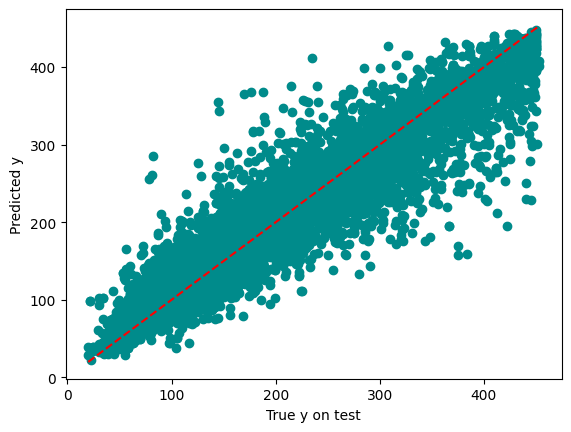

In [302]:
# Plot performance graph
plt.scatter(y_test, y_pred_rf_best_test, color='darkcyan')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red')
plt.xlabel("True y on test")
plt.ylabel("Predicted y")
plt.show()

**Final evaluation of features importance**

In [303]:
importances = best_rf.feature_importances_
feature_importance = pd.Series(importances, index=col_ind).sort_values(ascending=False)
#select only the first 70
select = feature_importance[:70]

In [337]:
feature_importance

durata                   0.126840
distanza                 0.079859
Wizz Air Malta           0.036554
Vueling                  0.029995
settimana_3              0.029048
                           ...   
Differenza_(1.0, 3.0]    0.000000
Differenza_(3.0, 7.0]    0.000000
Differenza_(0.0, 1.0]    0.000000
mese_8                   0.000000
Icelandair               0.000000
Length: 98, dtype: float64

In [338]:
feature_importance.index

Index(['durata', 'distanza', 'Wizz Air Malta', 'Vueling', 'settimana_3',
       'tipo', 'tariffa_Business', 'tariffa_Standard', 'Iberia',
       'tariffa_Economy', 'sab', 'Ryanair', 'Differenza_(60.0, inf]',
       'aeroporto_arrivo_ATH', 'Lufthansa', 'aeroporto_arrivo_ORY', 'dom',
       'ITA Airways', 'aeroporto_arrivo_BCN', 'settimana_1',
       'aeroporto_arrivo_KEF', 'settimana_2', 'aeroporto_arrivo_JTR',
       'partenza_8-16', 'Multiple_Operator', 'Differenza_(15.0, 30.0]',
       'Differenza_(30.0, 60.0]', 'aeroporto_arrivo_IBZ', 'mer',
       'TAP AIR PORTUGAL', 'aeroporto_arrivo_LGW', 'gio',
       'aeroporto_arrivo_DBV', 'aeroporto_arrivo_AMS', 'mar',
       'aeroporto_arrivo_LIS', 'aeroporto_arrivo_NCE', 'Wizz Air', 'KLM',
       'ven', 'arrivo_8-16', 'lun', 'aeroporto_arrivo_MLA', 'arrivo_16-24',
       'Aegean Airlines', 'partenza_16-24', 'aeroporto_arrivo_JMK',
       'aeroporto_partenza_CIA', 'partenza_0-8', 'aeroporto_partenza_FCO',
       'aeroporto_arrivo_STN', 'Diff

In [339]:
feature_importance.values

array([1.26840147e-01, 7.98590073e-02, 3.65537200e-02, 2.99954189e-02,
       2.90477552e-02, 2.76723383e-02, 2.58021482e-02, 2.36181173e-02,
       2.18823556e-02, 2.09557590e-02, 1.97379692e-02, 1.90770895e-02,
       1.89768815e-02, 1.86434838e-02, 1.79321889e-02, 1.69657142e-02,
       1.66938658e-02, 1.64956176e-02, 1.57355731e-02, 1.55690550e-02,
       1.54859339e-02, 1.49765719e-02, 1.44731228e-02, 1.44213674e-02,
       1.39407362e-02, 1.38036386e-02, 1.33015838e-02, 1.30555321e-02,
       1.26002754e-02, 1.25424859e-02, 1.22351888e-02, 1.15207174e-02,
       1.11771894e-02, 1.10280621e-02, 1.07756433e-02, 1.06683351e-02,
       1.06004832e-02, 1.03836952e-02, 1.01365956e-02, 9.00612650e-03,
       8.77814661e-03, 8.74999911e-03, 8.55307196e-03, 8.53455833e-03,
       8.51211543e-03, 7.83327203e-03, 7.51214677e-03, 7.13864650e-03,
       6.98387691e-03, 6.73259194e-03, 6.65351957e-03, 6.20770818e-03,
       5.78218932e-03, 4.68625768e-03, 4.34124268e-03, 4.15911450e-03,
      

In [304]:
select

durata                  0.126840
distanza                0.079859
Wizz Air Malta          0.036554
Vueling                 0.029995
settimana_3             0.029048
                          ...   
British Airways         0.002026
Norwegian               0.001591
aeroporto_arrivo_LHR    0.001470
Croatia Airlines        0.001274
aeroporto_arrivo_BVA    0.001183
Length: 70, dtype: float64

In [11]:
from tqdm.notebook import tqdm

var_list = select.index
loco_res = {}
# Numero di bootstrap samples
n_bootstrap_samples = 10 #era 100, magari fare una prova con altri valori 50, 10 etc
# Livello di significatività desiderato
alpha = 0.05
#var_imp --> list of var, take first 10

for feature in var_list:
    loco_scores = []
   
    for _ in tqdm(range(n_bootstrap_samples)): 
        X_train_loco, X_test_loco, y_train_loco, y_test_loco = train_test_split(XX,yy, test_size=0.2) #Randomly split the training data into two, non overlapping, parts
        
        reg = RandomForestRegressor(n_jobs=-1) #Run any algorithm you like to compute an estimate fn1 (·) on first part Dn1 .
        reg.fit(X_train_loco, y_train_loco)
        y_pred_loco = reg.predict(X_test_loco)
        baseline_metric = mean_squared_error(y_test_loco, y_pred_loco, squared=False)
        
        # Temporarily remove the current feature
        X_train_loco = X_train_loco.drop(feature, axis=1)
        X_test_loco = X_test_loco.drop(feature, axis=1)
        
        # Retrain the model on the modified dataset
        reg_temp = RandomForestRegressor()
        reg_temp.fit(X_train_loco, y_train_loco)
        # Make predictions on the modified dataset
        y_pred_temp = reg_temp.predict(X_test_loco)
        # Compute the r2_score and LOCO score
        metric_temp = mean_squared_error(y_test_loco, y_pred_temp, squared=False)
        loco_score = metric_temp - baseline_metric #def (l^-j - l) for each j in first_10  #devo mettere median qui?
        loco_scores.append(loco_score)
        
        
    loco_res[feature] = loco_scores #100 theta_j for each j 

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# Lista per memorizzare gli intervalli di confidenza delle mediane
n_bootstrap_samples = 10
alpha = 0.05
n_features = len(var_list)
bonferroni_correction = alpha / n_features
confidence_intervals = []
store = []
for elem in var_list:

    # Campione di loco scores
    bootstrap_loco = loco_res[elem]

    # Calcolo dell'intervallo di confidenza corretto di Bonferroni
    sorted_loco = np.sort(bootstrap_loco)
    store.append(np.median(sorted_loco))
    
    lower_bound = sorted_loco[int(n_bootstrap_samples * bonferroni_correction / 2)] #credo che al posto di 10 vada in numero di variabili che stiamo analizzando
    upper_bound = sorted_loco[int(n_bootstrap_samples * (1 - bonferroni_correction / 2))]# idem di quello sopra
    
    # Aggiunta dell'intervallo di confidenza alla lista
    confidence_intervals.append((round(lower_bound,4), round(upper_bound,4)))

# Stampa degli intervalli di confidenza corretti di Bonferroni per ciascuna variabile   #ritornare il nome della variabile
for i, interval in enumerate(confidence_intervals):
    print('-'*90)
    print(f'Variabile', var_list[i],': '+'confidence interval =', interval, ', LOCO score', round(store[i],4)) 
    #print(f"Variabile {i+1}: confidence interval = {interval}")
print('-'*90)